# Load Packages

In [8]:
import os
import sys, importlib
from functools import reduce
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
from dotenv import load_dotenv
# Load Session Id vom .env file to environment variables
load_dotenv()

True

In [10]:
# Append the path to the exploratory-analysis package and import
sys.path.append(os.environ.get('PATH_EXPLORATORY_ANALYSIS'))
import exploratory_analysis as ea

# Load Data

In [11]:
project_path=os.path.dirname(os.path.abspath(''))
superstore_data_path=os.path.join(project_path,"data","superstore.xls")

# Import data
dict_df=ea.import_to_pds(superstore_data_path)

# Print list of loaded tavles
print(f"List of tables: {list(dict_df.keys())}")

# Define dataframe variables
df_orders=dict_df["Orders"]
df_people=dict_df["People"]
df_returns=dict_df["Returns"]

List of tables: ['Orders', 'People', 'Returns']


# Basic Analysis and Preparations

## Orders Table

Inspect the data by printing the first rows:

In [12]:
df_orders.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,US-2019-103800,2019-01-03,2019-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,77095,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512
1,2,US-2019-112326,2019-01-04,2019-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540,Central,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540,2,0.8,-5.4870


Extract basic informations of the tables:

In [13]:
basic_analysis_result=ea.basic_analysis_df(df_orders)
df_basic_analysis=basic_analysis_result["df_info"]
num_cols=basic_analysis_result["num_cols"]
num_rows=basic_analysis_result["num_rows"]

Number of data and columns:

In [14]:
print(f"Number of data: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of data: 10194
Number of columns: 21


Extract basic informations:

In [15]:
df_basic_analysis

,col_nm,type,num_unique,num_null
0,Row ID,int64,10194,0
1,Order ID,object,5111,0
2,Order Date,datetime64[ns],1242,0
3,Ship Date,datetime64[ns],1338,0
4,Ship Mode,object,4,0
5,Customer ID,object,804,0
6,Customer Name,object,800,0
7,Segment,object,3,0
8,Country/Region,object,2,0
9,City,object,542,0


First observations:
* No null entries -> Data is clean. No further processing needed for handling gaps in the data.
* Row ID unique identifier for each data
* There are multiple data for an order (identifier: Order ID). About 2 for each order.

In [16]:
dict(df_orders[["Category","Sub-Category"]].groupby(["Category"])["Sub-Category"].unique())

{'Furniture': array(['Chairs', 'Furnishings', 'Bookcases', 'Tables'], dtype=object),
 'Office Supplies': array(['Paper', 'Binders', 'Labels', 'Storage', 'Art', 'Fasteners',
        'Envelopes', 'Appliances', 'Supplies'], dtype=object),
 'Technology': array(['Phones', 'Accessories', 'Machines', 'Copiers'], dtype=object)}

In [17]:
# Are the sub-categories unique?
dict_category_sub={category: sorted(sub_category) for category,sub_category in df_orders[["Category","Sub-Category"]].groupby(["Category"])["Sub-Category"].unique().items()}
print(dict_category_sub)
# Yes it is indeed unique 
li_sub_category=reduce(lambda x,y: x+y,dict_category_sub.values())

{'Furniture': ['Bookcases', 'Chairs', 'Furnishings', 'Tables'], 'Office Supplies': ['Appliances', 'Art', 'Binders', 'Envelopes', 'Fasteners', 'Labels', 'Paper', 'Storage', 'Supplies'], 'Technology': ['Accessories', 'Copiers', 'Machines', 'Phones']}


In [18]:
print(dict_category_sub)

{'Furniture': ['Bookcases', 'Chairs', 'Furnishings', 'Tables'], 'Office Supplies': ['Appliances', 'Art', 'Binders', 'Envelopes', 'Fasteners', 'Labels', 'Paper', 'Storage', 'Supplies'], 'Technology': ['Accessories', 'Copiers', 'Machines', 'Phones']}


In [19]:
print(list(dict_category_sub.values()))

[['Bookcases', 'Chairs', 'Furnishings', 'Tables'], ['Appliances', 'Art', 'Binders', 'Envelopes', 'Fasteners', 'Labels', 'Paper', 'Storage', 'Supplies'], ['Accessories', 'Copiers', 'Machines', 'Phones']]


## People Table

In [20]:
# Orders dataframe
df_people

,Regional Manager,Region
0,Sadie Pawthorne,West
1,Chuck Magee,East
2,Roxanne Rodriguez,Central
3,Fred Suzuki,South


## Return Table

In [21]:
# Orders dataframe
df_returns.head(2)


,Returned,Order ID
0,Yes,US-2019-100762
1,Yes,US-2019-100762


In [22]:
ea.basic_analysis.basic_analysis_df(df_returns)["df_info"]

,col_nm,type,num_unique,num_null
0,Returned,object,1,0
1,Order ID,object,296,0


## Create additional features

### Year, Month, and Day Columns

In [23]:
df_orders=ea.year_month_day_col(df_orders,"Order Date")


### Length of Shipping column
One possible interesting feature is the length of shipping, which is defined as the days passed between ordering and shipping

In [24]:
df_orders['Days Until Shipping'] = (df_orders['Ship Date'] - df_orders['Order Date']) / np.timedelta64(1, 'D')
df_orders['Days Until Shipping']=df_orders['Days Until Shipping'].astype(int)

### Return - Yes/No Column
To analyze the impact of churns to the company's profitability. We first need to input the churn information into the order dataframe. We do this by joining the returns table to the orders table.

In [25]:
df_orders=df_orders.merge(df_returns, on=['Order ID'], how='left')
df_orders["Returned"]=df_orders["Returned"].fillna("No")
df_orders.head(1)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Product Name,Sales,Quantity,Discount,Profit,year,month,day,Days Until Shipping,Returned
0,1,US-2019-103800,2019-01-03,2019-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512,2019,1,3,4,No


### One-Hot-Encoding of Categorical Data

In [26]:
# Columns to one-hot-encode 
li_one_hot=["Ship Mode","Segment","Region","Sub-Category","Returned"]

In [27]:
one_hot_result=ea.one_hot_encode(df_input=df_orders,li_one_hot=li_one_hot)
df_orders=one_hot_result["df_result"]
dummies_dict=one_hot_result["dummies_dict"]

# Correlation Analysis

For the correlation analysis, we first drop columns which we do not aim to analyze. Those are for instance ID columns. 

In [28]:
# Columns to drop
li_drop_corr=["Row ID","Order ID", "Order Date","Ship Date","Customer ID","Customer Name","Country/Region","State/Province","City","Postal Code","Product ID","Category","Product Name","year","month","day"]
# Drop the corresponding columns
df_for_corr=df_orders.drop(columns=li_drop_corr)

We visualize the correlation between the features in the following. In doing this, wo only consider non-negligible correlations, i.e. those whose absolute value > 0.1. 

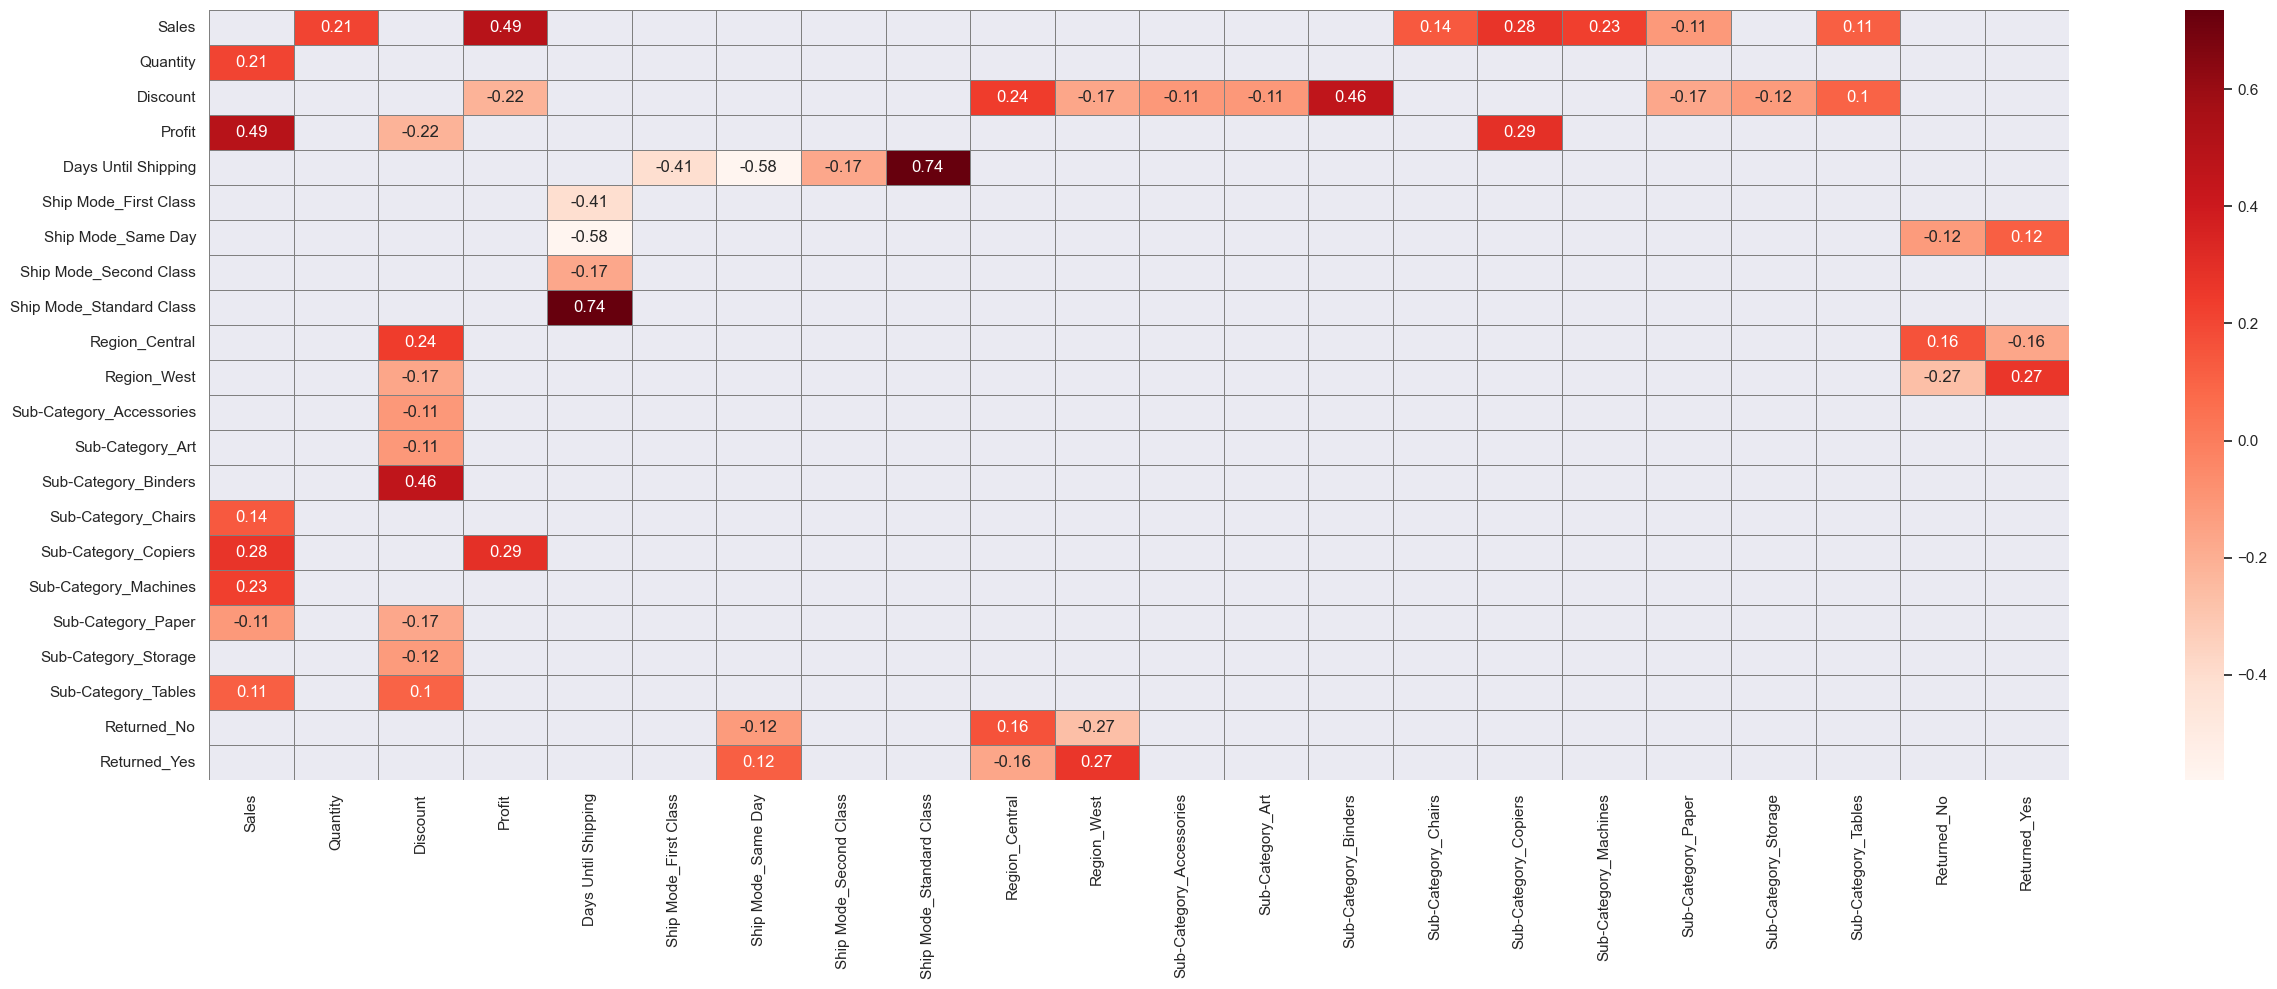

In [29]:
filtered_df=ea.show_corr_matrix_filtered(df_input=df_for_corr,dummies_dict=dummies_dict)

In [30]:
import plotly.express as px

fig = px.imshow(filtered_df,labels={"x":"x-Feature ", "y":"y-Feature", "color":"Correlation Coefficient"}, width=1000, aspect= "auto")
fig.update_xaxes(tickangle=45,ticksuffix = "  ")
fig.update_yaxes(tickangle=-45,ticksuffix = "  ")
fig.update_layout(
    title= "Correlation",
    font=dict(
        size=11,
    )
)
fig.show()

For convenience, we also visualize the correlations between the features by means of a graph. Red colored edges stand for negative correlations and green colored edges stand for positive correlation. The width of the edges is proportional with the absolute value of the correlation. Moreover we choose the size of the nodes to be proportional with the (eigenvalue) centrality of the nodes.

In [31]:
adjacency_matrix=filtered_df.fillna(0)
dict_labels={list(adjacency_matrix.columns).index(col):col for col in list(adjacency_matrix.columns)}
adjacency_matrix=adjacency_matrix.to_numpy()

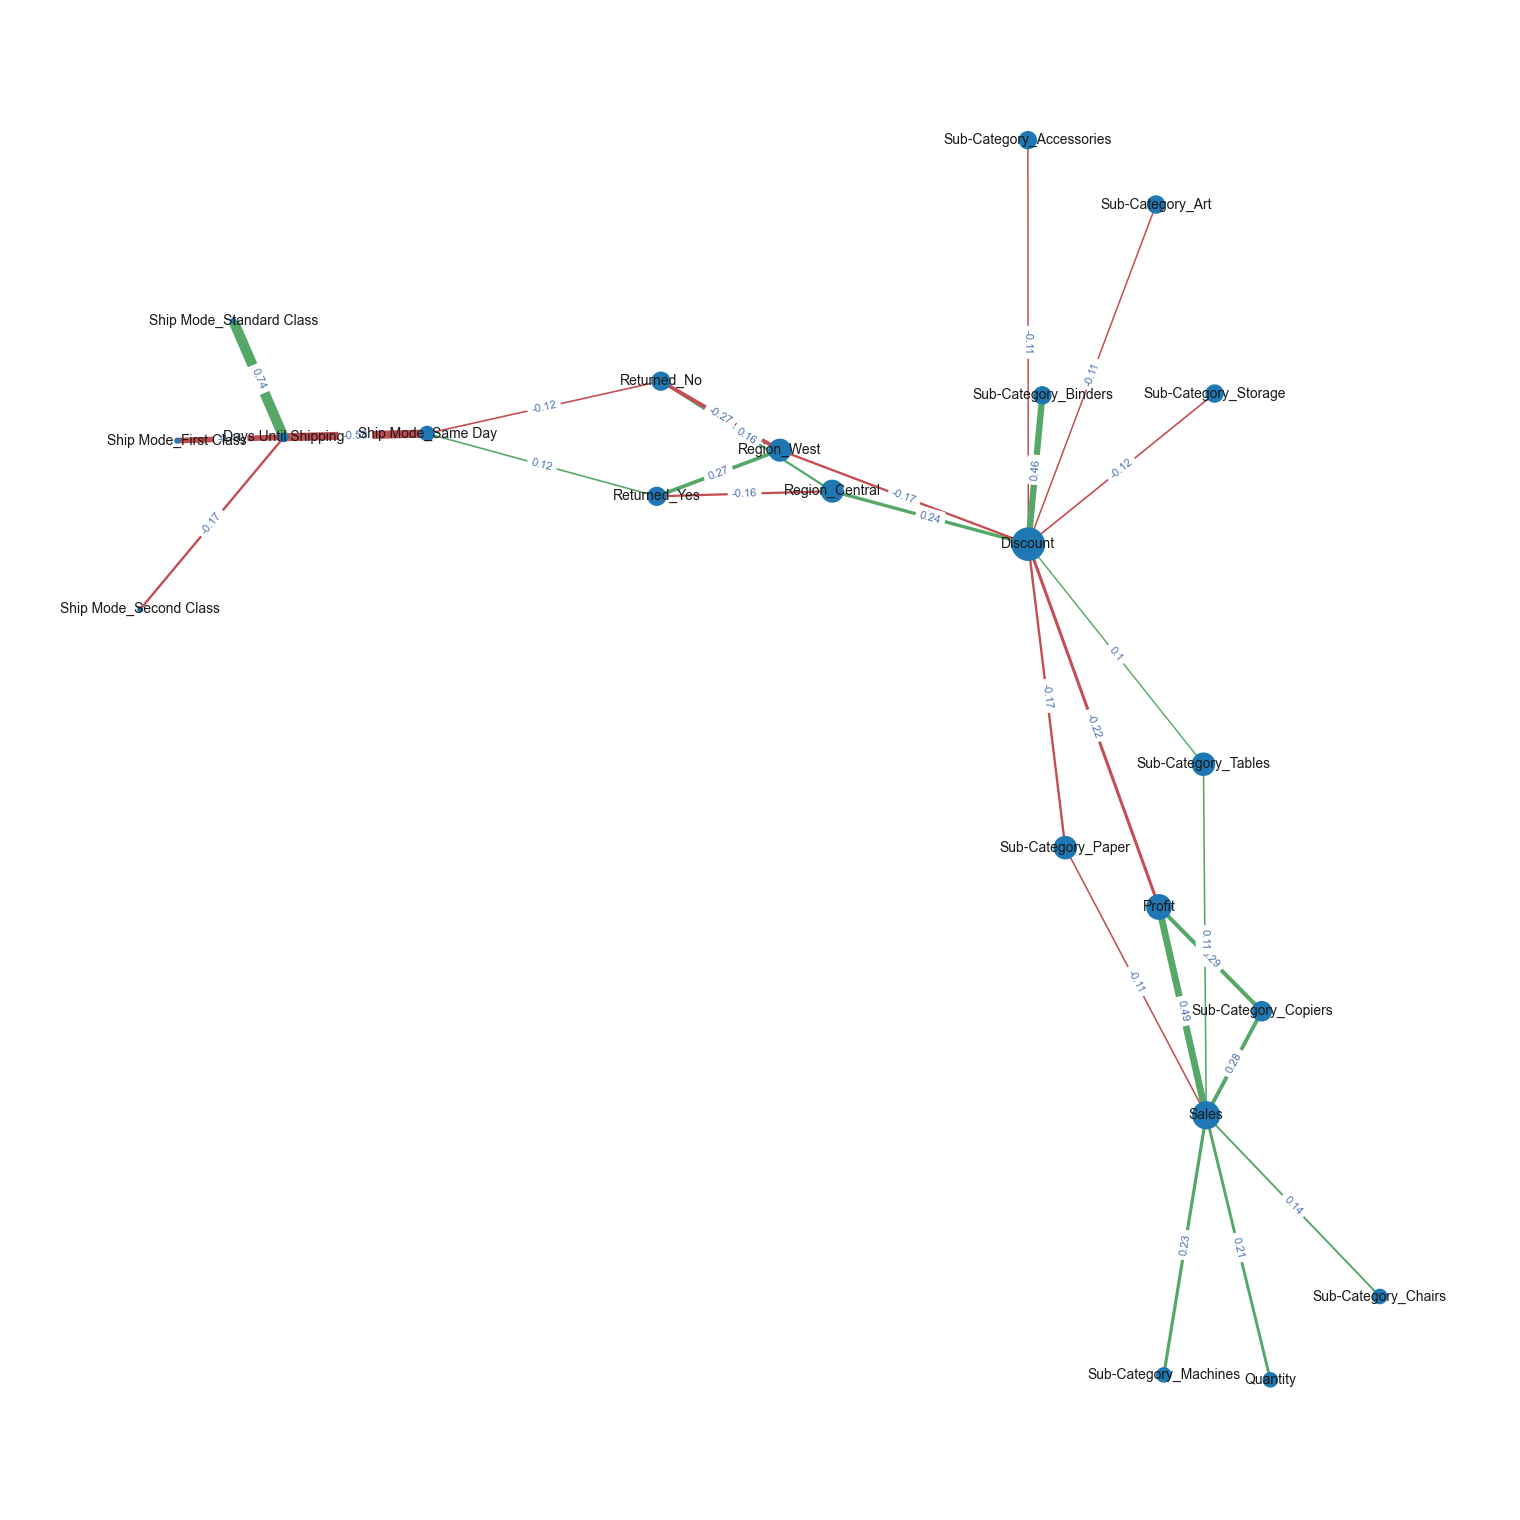

In [32]:
graph_handle=ea.show_graph_with_labels(adjacency_matrix,dict_labels,"eigenvector")

In [161]:
from typing import Dict, Optional,Callable,Union,Tuple
import networkx as nx

In [407]:
from typing import Dict, Optional, Callable, Union, Tuple, List
from collections import defaultdict
import networkx as nx
import plotly.graph_objects as go

class GraphFromAdjacencyMatrix:
    """
    Usage:
    def _coloring_by_sign(num_input: float)->str:
    if num_input<= 0:
         return 'r'
    return 'g'

    GraphObject=GraphFromAdjacencyMatrix(
        adjacency_matrix=adjacency_matrix,
        node_labels=dict_labels,centrality='eigenvector',
        func_edge_coloring=_coloring_by_sign,
        func_edge_weight=lambda val: abs(val * 10),
        func_edge_label=lambda val: np.round(val, 2))
    """

    def __init__(self, 
                 adjacency_matrix:np.ndarray, 
                 node_labels:Dict[int,str], 
                 func_edge_coloring: Callable[[float],str],
                 func_edge_weight: Callable[[float],float],
                 func_edge_label: Callable[[float],Union[str,int]],
                 adjust_node_size_from_centrality: Optional[bool]=True,
                 centrality:Optional[str]="eigenvector"
                 )->None:
        self.adjacency_matrix = adjacency_matrix
        self.centrality=centrality

        nodes = list(range(len(adjacency_matrix)))
        rows, cols = np.where(adjacency_matrix != 0)
        edges = zip(rows.tolist(), cols.tolist())

        # Create graph
        self.nx_graph = nx.Graph()
        self.nx_graph.add_nodes_from(nodes)

        for _edge in edges:
            _val_adjacency= adjacency_matrix[_edge]
            self.nx_graph.add_edge(
                *_edge, 
                color=func_edge_coloring(_val_adjacency), 
                weight=func_edge_weight(_val_adjacency), 
                label=func_edge_label(_val_adjacency)
            )

        # Add node label
        nx.set_node_attributes(self.nx_graph, node_labels, name = "label")
        
        # Compute Position
        # Apply algorithm to compute best node placement
        self.pos = nx.spring_layout(self.nx_graph)

        # Add position to graph object
        for _node, _pos in self.pos.items():
            self.nx_graph.nodes[_node]['pos'] = _pos

        # add edge positions to the graph object
        for _edge in self.nx_graph.edges:
            self.nx_graph.edges[_edge]['pos'] = (self.pos[_edge[0]],self.pos[_edge[1]])
        
        if adjust_node_size_from_centrality is None:
            pass
        
        centrality_method = dict(
            degree="degree_centrality",
            load="load_centrality",
            eigenvector="eigenvector_centrality"
            )
        nx.set_node_attributes(self.nx_graph, getattr(nx, centrality_method[centrality])(self.nx_graph), name = "centrality")

    def plot_sns(self,figsize: Optional[Tuple[int,int]]=(15, 15),font_sizes:Optional[Dict[str,int]]=None) -> None:

        if font_sizes is None:
            font_sizes = {"node": 10, "edge": 8}

        plt.figure(figsize=figsize)

        _pos = list(nx.get_node_attributes(self.nx_graph,"pos").values())

        nx.draw(
            self.nx_graph,
            pos = _pos,
            labels=nx.get_node_attributes(self.nx_graph,"label"),
            node_size= list(nx.get_node_attributes(self.nx_graph,"size").values()),
            with_labels=True,
            edge_color=list(nx.get_edge_attributes(self.nx_graph, "color").values()),
            width=list(nx.get_edge_attributes(self.nx_graph, "weight").values()),
            font_size=font_sizes["node"],
        )
        nx.draw_networkx_edge_labels(
            self.nx_graph,
            pos=_pos,
            edge_labels=nx.get_edge_attributes(self.nx_graph,"label"),
            font_size=font_sizes["edge"],
            font_color="b",
        )
        plt.show()

        return None
    
    def _create_plotly_nodes(self) -> None:

        node_trace = go.Scatter(
            x=[_pos[0]for _pos in nx.get_node_attributes(self.nx_graph,"pos").values()], 
            y=[_pos[1]for _pos in nx.get_node_attributes(self.nx_graph,"pos").values()],
            mode='markers',
            hoverinfo='text',
            marker=
                dict(
                    showscale=True,
                    colorscale='YlGnBu',
                    reversescale=True,
                    color=[],
                    size=10,
                    colorbar=
                        dict(
                            thickness=15,
                            title='Centrality',
                            xanchor='left',
                            titleside='right'
                        ),
                    line_width=2
                )
        )
        
        node_text = []

        node_adjacencies = []
        for node, adjacencies in enumerate(self.nx_graph.adjacency()):
            node_adjacencies.append(len(adjacencies[1]))
            node_text.append('# of connections: '+str(len(adjacencies[1])))

        print(nx.get_node_attributes(self.nx_graph,"size"))

        node_trace.marker.color = list(nx.get_node_attributes(self.nx_graph,"centrality").values())
        node_trace.marker.size = [centrality*100 for centrality in nx.get_node_attributes(self.nx_graph,"centrality").values()]
        node_trace.text = [f"Graph Centrality: {centrality:.2f}" for centrality in nx.get_node_attributes(self.nx_graph,"centrality").values()]

        return node_trace
    
    def _create_plotly_edges(self) -> None:

        edge_x = []
        edge_y = []

        edge_text = []
        for edge in self.nx_graph.edges():
            x0, y0 = self.nx_graph.nodes[edge[0]]['pos']
            x1, y1 = self.nx_graph.nodes[edge[1]]['pos']
            edge_x.extend([x0,x1,None])
            edge_y.extend([y0,y1,None])
            edge_text.append(f'Correlation Coefficient: {nx.get_edge_attributes(self.nx_graph,"label")[edge]}')

        edge_trace=go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=0.5, color='#888'),
            hoverinfo='text',
            mode='lines',
        )
        
        #edge_trace.text=edge_text
        #edge_trace.marker.size = list(nx.get_edge_attributes(self.nx_graph,"weight").values())

        return edge_trace
    
    def _create_edge_traces(self) -> List[Union[go.Scatter, go.Scatter3d]]:
        # group all edges by (color, width)
        groups = defaultdict(list)

        for edge in self.nx_graph.edges():
            color = self._get_setting('edge_color', edge)
            width = self._get_setting('edge_width', edge)
            groups[(color, width)] += [edge]

        # process each group
        traces = []

        for edge in self.nx_graph.edges:
            (x0,y0), (x1,y1) = self.nx_graph.edges['pos']
            params = dict(
                x=[x0,x1,None],
                y=[y0,y1,None],
                mode='lines',
                hoverinfo='none',
                line=dict(
                    color=self.nx_graph.edges[edge]['color'], 
                    width=self.nx_graph.edges[edge]['size']
                    ),
                #opacity=self._get_setting('edge_opacity'),
            )
            traces += [go.Scatter(**params)]

        return traces

    def plot_plotly(self) -> None:

        fig = go.Figure(data=[self._create_plotly_nodes()],
             layout=go.Layout(
                title='<br>Hier ein Titel',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ 
                    dict(
                            text="Hier kann ein Text stehen",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002 
                        ) 
                    ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
        fig.add_traces(self._get_edge_traces())
        

        
        fig.show()
        

In [390]:
def _coloring_by_sign(num_input: float)->str:
    if num_input<= 0:
         return "r"
    return "g"

GraphObject=GraphFromAdjacencyMatrix(
    adjacency_matrix=adjacency_matrix,
    node_labels=dict_labels,centrality="eigenvector",
    func_edge_coloring=_coloring_by_sign,
    func_edge_weight=lambda val: abs(val * 10),
    func_edge_label=lambda val: np.round(val, 2))

In [402]:
(x0,y0),(x1,y1)=GraphObject.nx_graph.edges[(0, 3)]["pos"]

In [405]:
x1

0.4429866703063186

In [397]:
GraphObject.nx_graph.nodes[0]['pos']

array([0.65144927, 0.03110563])

In [391]:
GraphObject.plot_plotly()

{}


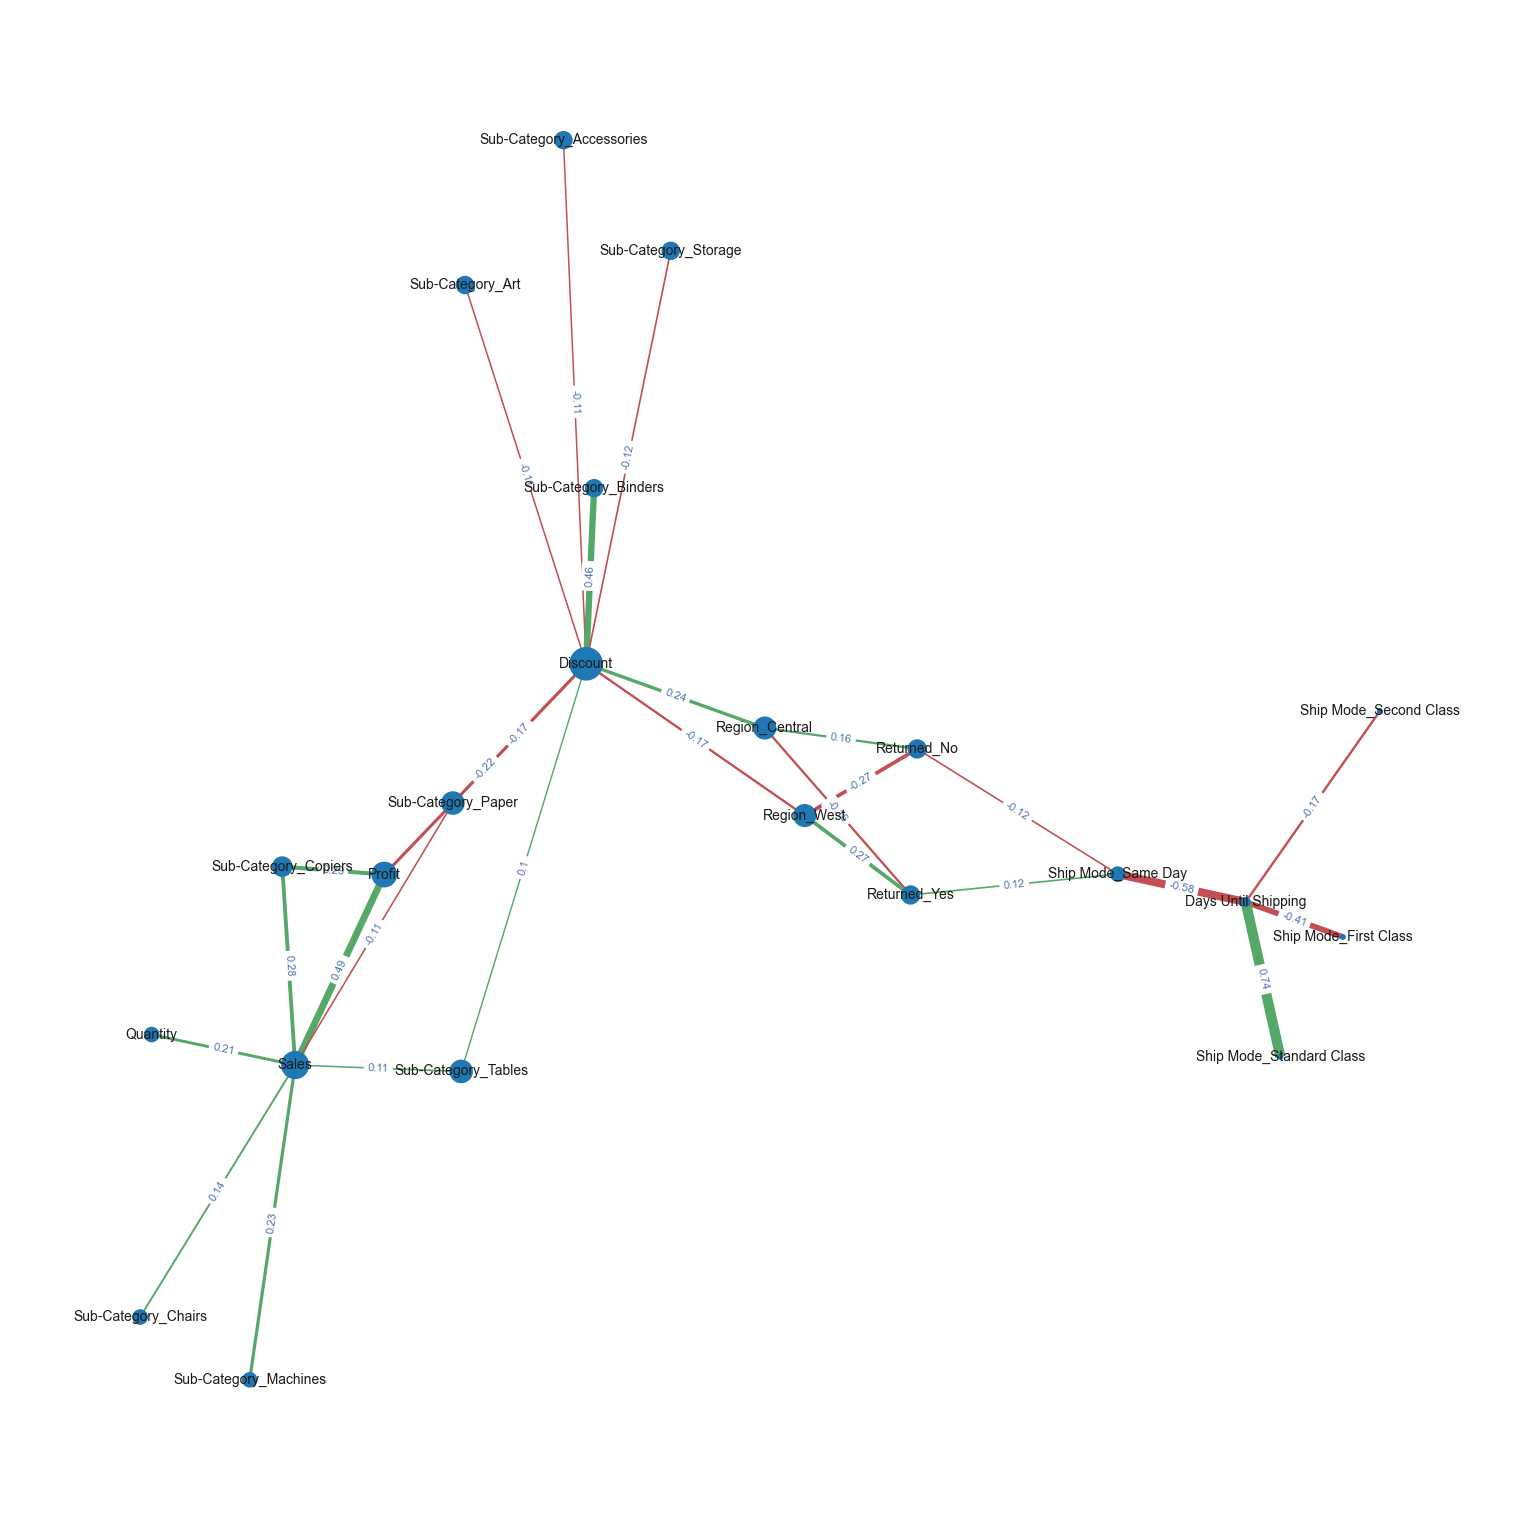

In [277]:
GraphObject.plot_sns()

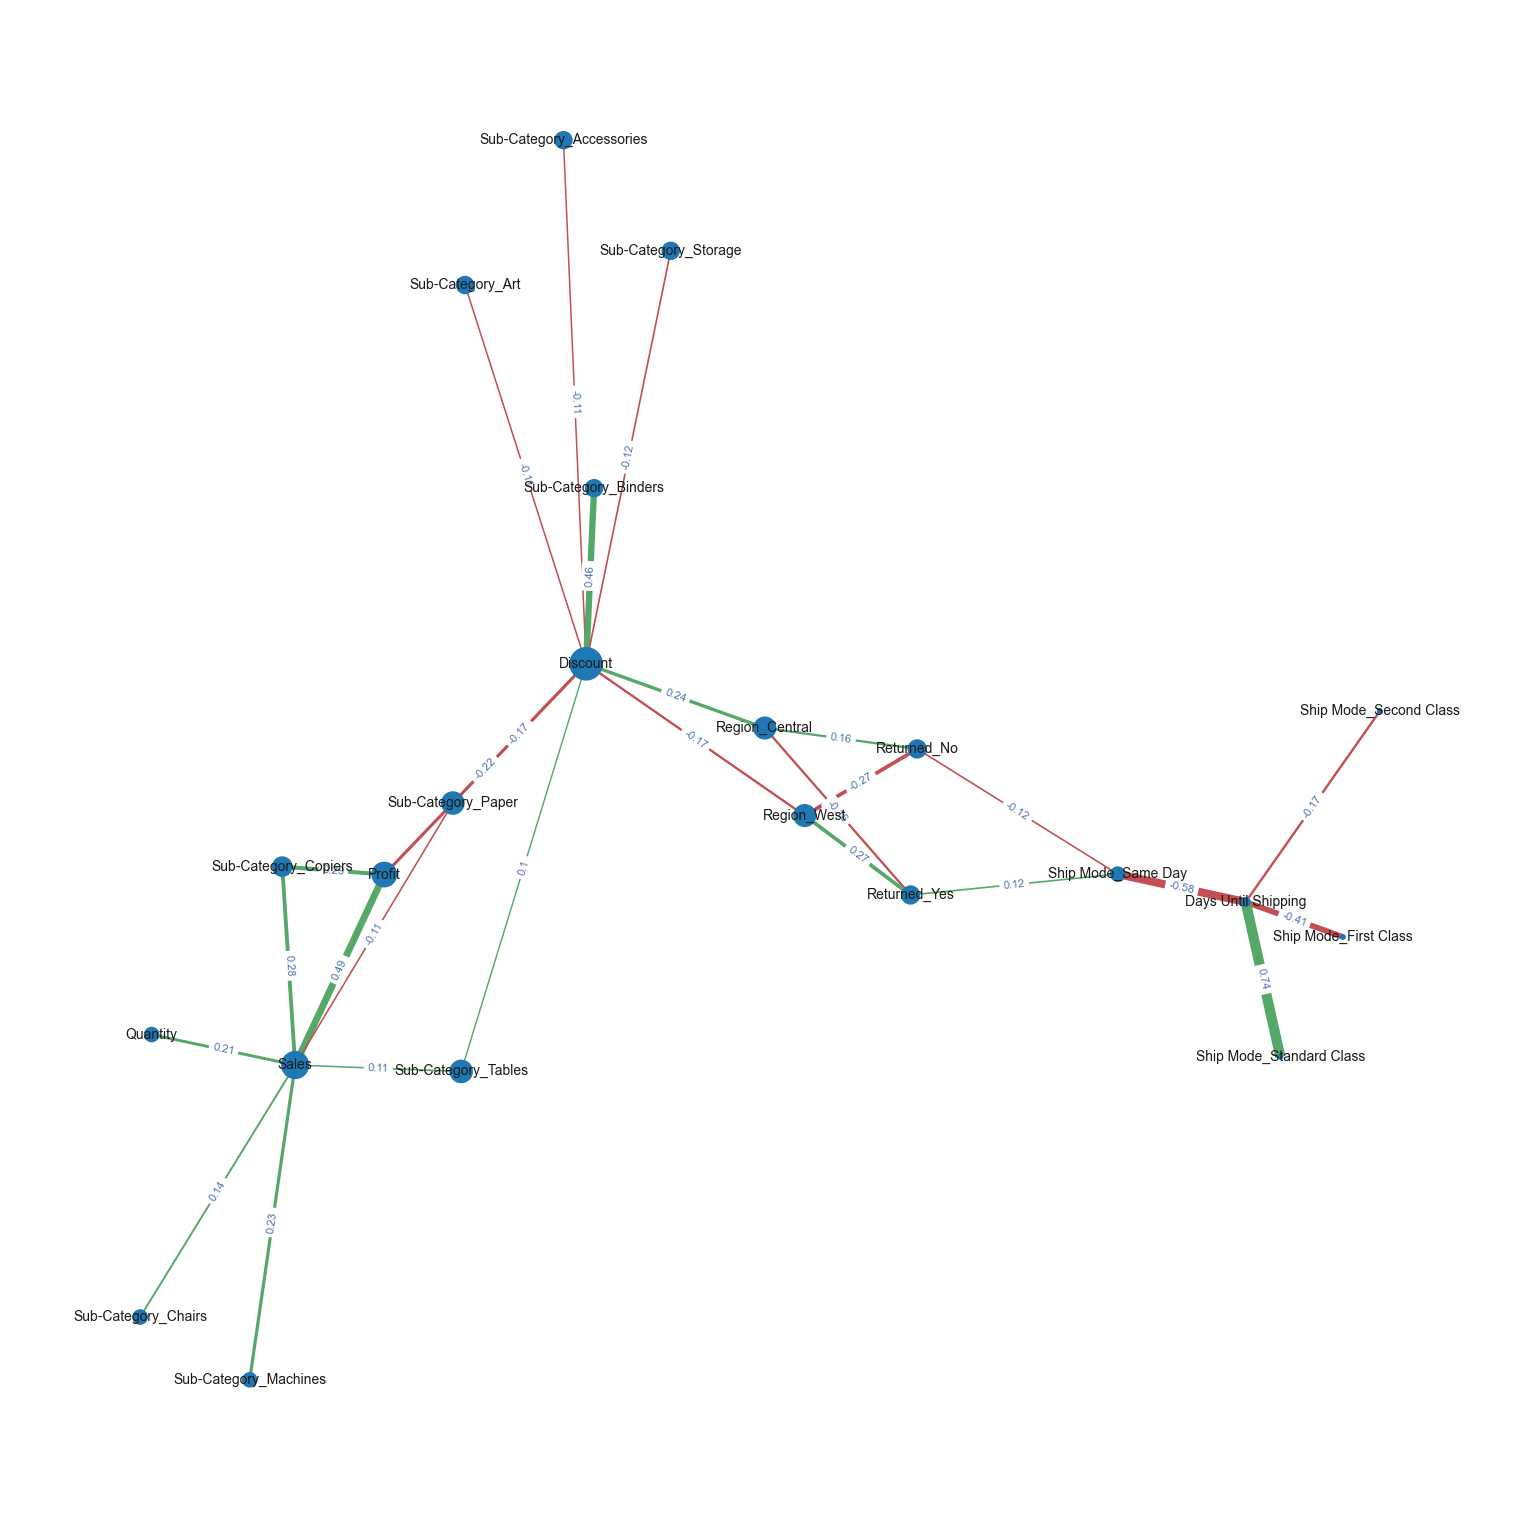

In [ ]:
GraphObject.plot_sns()

In [107]:
def show_graph_with_labels(
    adjacency_matrix: np.ndarray,
    mylabels: Dict[int, str],
    centrality: str,
    figsize=(15, 15),
    font_sizes: Optional[Dict[str, int]] = None,
) -> None:
    """Create a graph visualizing the correlation between features.
    Only correlations with absolute value > 0.1 are depicted.
    Red (resp. green) edges are for negative (resp. positive) correlations.
    Width of the edge is proportional to the absolute value of the correlation.
    Size of the node is proportional to the centrality of the node

    Args:
        adjacency_matrix (np.ndarray): Adjacency matrix
        mylabels (Dict[int, str]): Labels - Index: Label
        centrality (str): Centrality computation method
        figsize (tuple, optional): Size of the figure.
            Defaults to (15, 15).
        font_sizes (_type_, optional): Font size. Dict
            for node and edge
            Defaults to dict(node=10, edge=8).
    """
    if font_sizes is None:
        font_sizes = {"node": 10, "edge": 8}
    
    nodes = list(range(len(adjacency_matrix)))
    rows, cols = np.where(adjacency_matrix != 0)
    edges = zip(rows.tolist(), cols.tolist())

    # Create graph
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    edge_labels = {}
    # The color can be realized by a function
    for edge in edges:
        if adjacency_matrix[edge] < 0:
            color = "r"
        elif adjacency_matrix[edge] > 0:
            color = "g"
        graph.add_edge(
            edge[0], edge[1], color=color, weight=abs(adjacency_matrix[edge] * 10)
        )
        edge_labels[(edge[0], edge[1])] = np.round(adjacency_matrix[edge], 2)
    
    # Apply algorithm to compute best node placement
    pos = nx.spring_layout(graph,k=0.5, iterations=50)

    # Add position to graph object
    for _node, _pos in pos.items():
        graph.nodes[_node]['pos'] = _pos

    # add edge positions to the graph object
    for _edge in graph.edges:
        graph.edges[_edge]['pos'] = (pos[_edge[0]],pos[_edge[1]])

    centrality_method = dict(
        degree="degree_centrality",
        load="load_centrality",
        eigenvector="eigenvector_centrality",
    )

    centrality = getattr(nx, centrality_method[centrality])(graph)

    plt.figure(figsize=figsize)
    colors = nx.get_edge_attributes(graph, "color").values()
    weights = nx.get_edge_attributes(graph, "weight").values()

    nx.draw(
        graph,
        pos,
        labels=mylabels,
        node_size=[v * 1000 for v in centrality.values()],
        with_labels=True,
        edge_color=colors,
        width=list(weights),
        font_size=font_sizes["node"],
    )
    nx.draw_networkx_edge_labels(
        graph,
        pos,
        edge_labels=edge_labels,
        font_size=font_sizes["edge"],
        font_color="b",
    )
    plt.show()

    # nodes position and edges weights and position already contained here
    return graph

In [81]:
rows, cols = np.where(adjacency_matrix != 0)
cols

array([ 1,  3, 14, 15, 16, 17, 19,  0,  3,  9, 10, 11, 12, 13, 17, 18, 19,
        0,  2, 15,  5,  6,  7,  8,  4,  4, 20, 21,  4,  4,  2, 20, 21,  2,
       20, 21,  2,  2,  2,  0,  0,  3,  0,  0,  2,  2,  0,  2,  6,  9, 10,
        6,  9, 10])

In [91]:
pos

{0: array([-0.11144075,  0.0116756 ]),
 1: array([ 0.14446977, -0.27713674]),
 2: array([0.10683678, 0.47639876]),
 3: array([-0.12240091,  0.20388159]),
 4: array([-0.17448845, -0.74783533]),
 5: array([-0.18142888, -1.        ]),
 6: array([ 0.07732783, -0.52713565]),
 7: array([-0.56727871, -0.73775293]),
 8: array([-0.30586877, -0.8639275 ]),
 9: array([0.37111082, 0.23061674]),
 10: array([0.43397626, 0.12542727]),
 11: array([0.35721712, 0.8960973 ]),
 12: array([0.06916771, 0.95738747]),
 13: array([0.23400452, 0.46955704]),
 14: array([-0.17521108, -0.36457908]),
 15: array([-0.31611627,  0.07956541]),
 16: array([ 0.0676556 , -0.15054981]),
 17: array([-0.10258118,  0.44004668]),
 18: array([-0.35327731,  0.62461153]),
 19: array([-0.2865501 ,  0.37242538]),
 20: array([ 0.3624768 , -0.09511869]),
 21: array([ 0.47239922, -0.12365503])}

In [93]:
for n, p in pos.items():
    graph_handle.nodes[n]['pos'] = p

In [116]:
graph_handle.edges[(0, 1)]["pos"]

(array([ 0.63380406, -0.09701774]), array([ 0.95023774, -0.04994518]))

In [90]:
graph_handle

In [84]:
import plotly.graph_objects as go

In [89]:
pos

{0: array([-0.11144075,  0.0116756 ]),
 1: array([ 0.14446977, -0.27713674]),
 2: array([0.10683678, 0.47639876]),
 3: array([-0.12240091,  0.20388159]),
 4: array([-0.17448845, -0.74783533]),
 5: array([-0.18142888, -1.        ]),
 6: array([ 0.07732783, -0.52713565]),
 7: array([-0.56727871, -0.73775293]),
 8: array([-0.30586877, -0.8639275 ]),
 9: array([0.37111082, 0.23061674]),
 10: array([0.43397626, 0.12542727]),
 11: array([0.35721712, 0.8960973 ]),
 12: array([0.06916771, 0.95738747]),
 13: array([0.23400452, 0.46955704]),
 14: array([-0.17521108, -0.36457908]),
 15: array([-0.31611627,  0.07956541]),
 16: array([ 0.0676556 , -0.15054981]),
 17: array([-0.10258118,  0.44004668]),
 18: array([-0.35327731,  0.62461153]),
 19: array([-0.2865501 ,  0.37242538]),
 20: array([ 0.3624768 , -0.09511869]),
 21: array([ 0.47239922, -0.12365503])}

In [ ]:
go.Scatter(
                x=_x,
                y=_y,
                mode='lines',
                hoverinfo='none',
                line=dict(color=nx.get_edge_attributes(graph_handle, "color"), width=nx.get_edge_attributes(graph_handle, "weight")),
            )

In [ ]:
# Custom function to create an edge between node x and node y, with a given text and width
def make_edge(source: int, target: int, text:, width):
    return  go.Scatter(x         = x,
                       y         = y,
                       line      = dict(width = width,
                                   color = 'cornflowerblue'),
                       hoverinfo = 'text',
                       text      = ([text]),
                       mode      = 'lines')

In [106]:
for edge in graph_handle.edges:
    print(edge)

(0, 1)
(0, 3)
(0, 14)
(0, 15)
(0, 16)
(0, 17)
(0, 19)
(2, 3)
(2, 9)
(2, 10)
(2, 11)
(2, 12)
(2, 13)
(2, 17)
(2, 18)
(2, 19)
(3, 15)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(6, 20)
(6, 21)
(9, 20)
(9, 21)
(10, 20)
(10, 21)


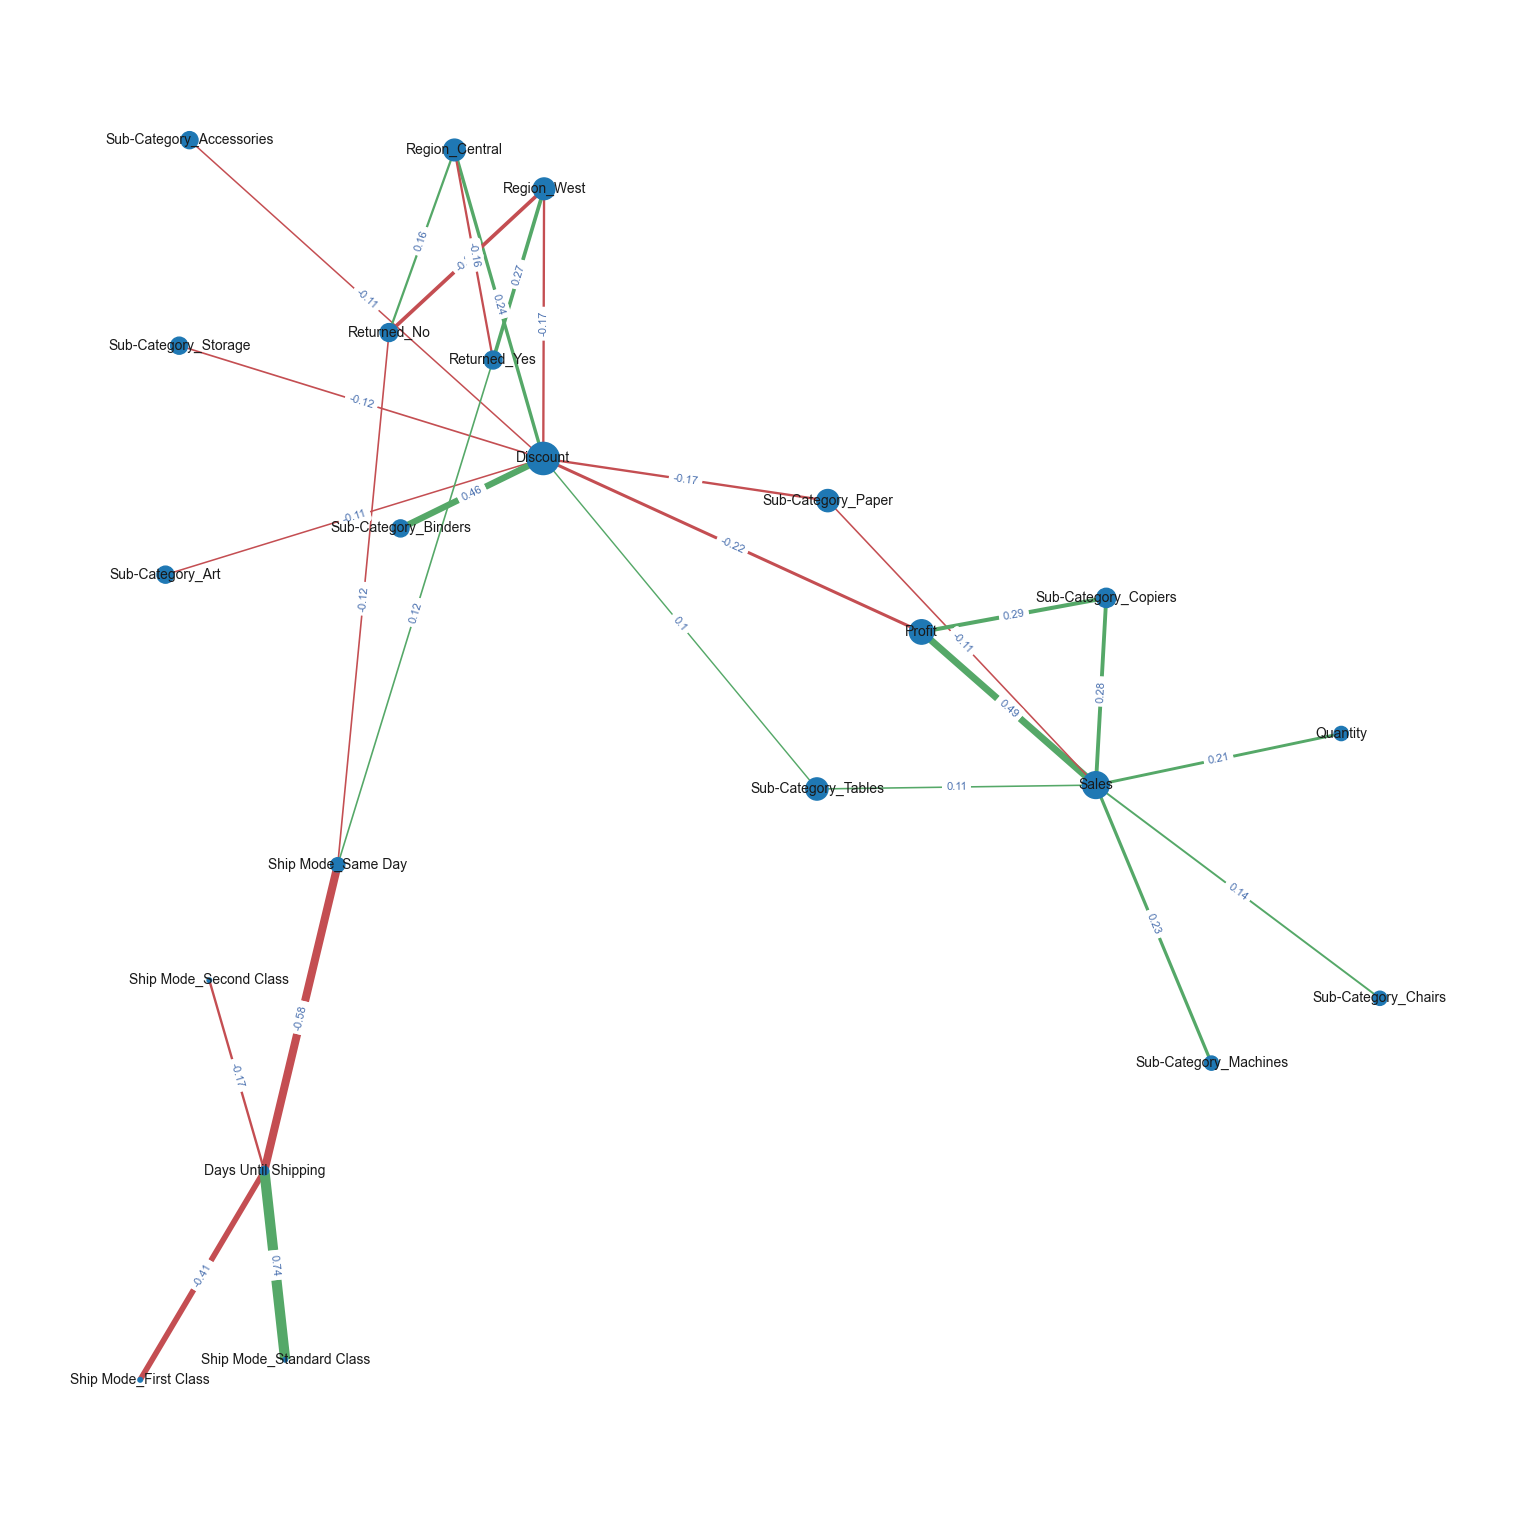

In [108]:
graph_handle=show_graph_with_labels(adjacency_matrix,dict_labels,"eigenvector")

In [82]:
nx.get_edge_attributes(graph_handle, "color").values()

dict_values(['g', 'g', 'g', 'g', 'g', 'r', 'g', 'r', 'g', 'r', 'r', 'r', 'g', 'r', 'r', 'g', 'g', 'r', 'r', 'r', 'g', 'r', 'g', 'g', 'r', 'r', 'g'])

In [104]:
nx.get_edge_attributes(graph_handle,'weight')

{(0, 1): 2.1015579188371807,
 (0, 3): 4.93813856494015,
 (0, 14): 1.3935798388079854,
 (0, 15): 2.7821147994891704,
 (0, 16): 2.3097764860329866,
 (0, 17): 1.1365341437554286,
 (0, 19): 1.143640136829423,
 (2, 3): 2.1933567856415017,
 (2, 9): 2.4182175319888404,
 (2, 10): 1.6808062235934453,
 (2, 11): 1.0856954959656695,
 (2, 12): 1.1111804722667438,
 (2, 13): 4.556867135155604,
 (2, 17): 1.7062415270963118,
 (2, 18): 1.2073766795431493,
 (2, 19): 1.0283168702240666,
 (3, 15): 2.921240294907555,
 (4, 5): 4.081141744486515,
 (4, 6): 5.793802110770248,
 (4, 7): 1.713235957166159,
 (4, 8): 7.355028971404195,
 (6, 20): 1.1755205692729096,
 (6, 21): 1.1755205692729112,
 (9, 20): 1.6358342582279226,
 (9, 21): 1.6358342582279242,
 (10, 20): 2.675365581660129,
 (10, 21): 2.6753655816601336}

In [55]:
pos = nx.spring_layout(graph_handle, k=0.5, iterations=50)
pos

{0: array([-0.11144075,  0.0116756 ]),
 1: array([ 0.14446977, -0.27713674]),
 2: array([0.10683678, 0.47639876]),
 3: array([-0.12240091,  0.20388159]),
 4: array([-0.17448845, -0.74783533]),
 5: array([-0.18142888, -1.        ]),
 6: array([ 0.07732783, -0.52713565]),
 7: array([-0.56727871, -0.73775293]),
 8: array([-0.30586877, -0.8639275 ]),
 9: array([0.37111082, 0.23061674]),
 10: array([0.43397626, 0.12542727]),
 11: array([0.35721712, 0.8960973 ]),
 12: array([0.06916771, 0.95738747]),
 13: array([0.23400452, 0.46955704]),
 14: array([-0.17521108, -0.36457908]),
 15: array([-0.31611627,  0.07956541]),
 16: array([ 0.0676556 , -0.15054981]),
 17: array([-0.10258118,  0.44004668]),
 18: array([-0.35327731,  0.62461153]),
 19: array([-0.2865501 ,  0.37242538]),
 20: array([ 0.3624768 , -0.09511869]),
 21: array([ 0.47239922, -0.12365503])}

In [83]:
edge_x = []
edge_y = []
for edge in graph_handle.edges():
    x0, y0 = graph_handle.nodes[edge[0]]['pos']
    x1, y1 = graph_handle.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

KeyError: 'pos'

In [119]:
graph_handle.edges[(0,1)]

{'color': 'g',
 'weight': 2.1015579188371807,
 'pos': (array([ 0.63380406, -0.09701774]), array([ 0.95023774, -0.04994518]))}

* All the shipping variables are correlated with the days until shipping. As the different modes of shipping are characterized by the days until shipping. Specifically, we have that products with:
    * same day shipping tend to have shorter number of shipping days, i.e. it is = 0,
    * standard class shipping tend to have higher numbers of shipping days,
    * first class and second class tend to have lower number of shipping days, whereas we expect that products shipped first class have lower number of shipping days in comparison with second class (correlation coefficient has higher absolute value).
* Whether a product has same day shipping option is correlated with the variable whether it is returned or not. We have both correlations:
    * Products with same day shipping option tend to be returned
    * Products without same day shipping tend to not be 
* Some insights about the business in the west region:
    * Orders in the west region tend to be returned
    * Products sold in the west region tend to have lower discount
* Some insights about the business in the central region:
    * Orders in the central region tend to not be returned
    * Products sold in the central region tend to have higher discount
* Discount and categories:
    * Categories with higher discount: Binders and tables
    * Categories with lower discounts: Accessories, storage, art, and papers
* Discount might have negative effect to profit as it may lower the price of products. The quantity seems not to be influenced by sales. Therefore, higher discount in general does not boost sales.
* Some insights about sales:
    * Sales and profit are positively correlated 
    * Category with lower sales: Paper -> Plausible as products from category paper have lower price 
    * Category with higher sales: Copiers, machines, chairs -> Plausible as products from those categories are heavier and thus have higher price
    * Higher quantity yields higher sales
* Nice triangle: Profit-sales-copiers -> Selling products in the copiers category might be a good business as it yields higher sales and profit
* Not so bad triangle: Profit-sales-papers-discount -> Selling paper products might be not a bad business. It yields lower sales and lower profit but tend not to be discounted

* Bad triangle: Table-discount-profit-and-sales -> Table products tend to be discounted. This discount might boost sales. However, there is no hint about higher profit. So the effect of higher sales by discount might have no or negative effect to profitability of the business

# Analysis Product from Tables sub-category

In [121]:
orders_earned=df_orders[df_orders["Returned"]=="No"]

In [122]:
#data_temp=orders_earned.groupby(["Region","Sub-Category"],as_index=False)[["Sales","Quantity","Profit"]].sum()
data_temp=orders_earned.groupby(["Region","Sub-Category"])[["Sales","Quantity","Profit"]].sum()
data_temp["Profit Sign"]=data_temp["Profit"].apply(np.sign)

In [123]:
data_temp.xs('Central')

,Sales,Quantity,Profit,Profit Sign
Sub-Category,,,,
Accessories,32419.2340,677,7128.7216,1.0
Appliances,23183.3950,455,-2558.3991,-1.0
Art,5235.9780,654,1090.7058,1.0
Binders,55473.3680,1383,3017.8171,1.0
Bookcases,23663.7384,182,-1975.2899,-1.0
Chairs,83487.7120,616,7021.3533,1.0
Copiers,37259.5700,49,15608.8413,1.0
Envelopes,4562.5200,203,1750.5757,1.0
Fasteners,775.1340,225,236.1480,1.0


In [124]:
li_sub_category

['Bookcases',
 'Chairs',
 'Furnishings',
 'Tables',
 'Appliances',
 'Art',
 'Binders',
 'Envelopes',
 'Fasteners',
 'Labels',
 'Paper',
 'Storage',
 'Supplies',
 'Accessories',
 'Copiers',
 'Machines',
 'Phones']

In [125]:
print(data_temp)

                           Sales  Quantity      Profit  Profit Sign
Region  Sub-Category                                               
Central Accessories   32419.2340       677   7128.7216          1.0
        Appliances    23183.3950       455  -2558.3991         -1.0
        Art            5235.9780       654   1090.7058          1.0
        Binders       55473.3680      1383   3017.8171          1.0
        Bookcases     23663.7384       182  -1975.2899         -1.0
...                          ...       ...         ...          ...
West    Paper         22340.8060      1434  10115.1502          1.0
        Phones        85777.5880       931   8007.5539          1.0
        Storage       62544.8460       911   8069.7879          1.0
        Supplies      17122.3860       202    564.9391          1.0
        Tables        74442.2220       408   1300.2969          1.0

[68 rows x 4 columns]


In [127]:
TextClass=ea.MultiIdxDF(multi_idx_df=data_temp)

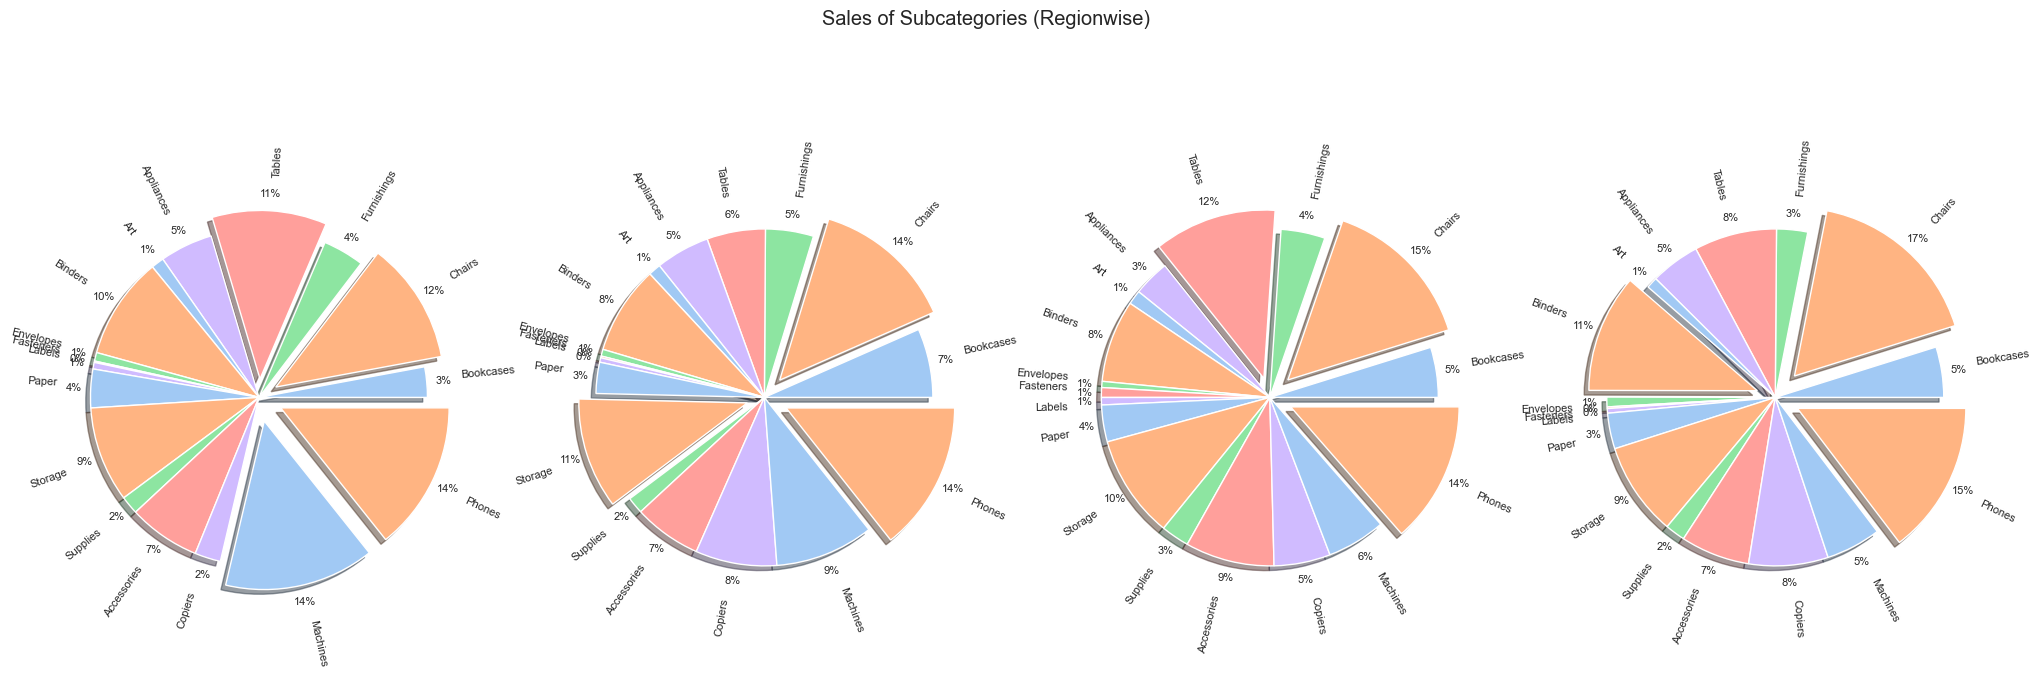

In [128]:
ea.create_pie_chart_from_multi_idx_df(
    multi_idx_df=data_temp,
    title="Sales of Subcategories (Regionwise)",
    col_plotted="Sales",
    ordering_sub_category=li_sub_category
    )

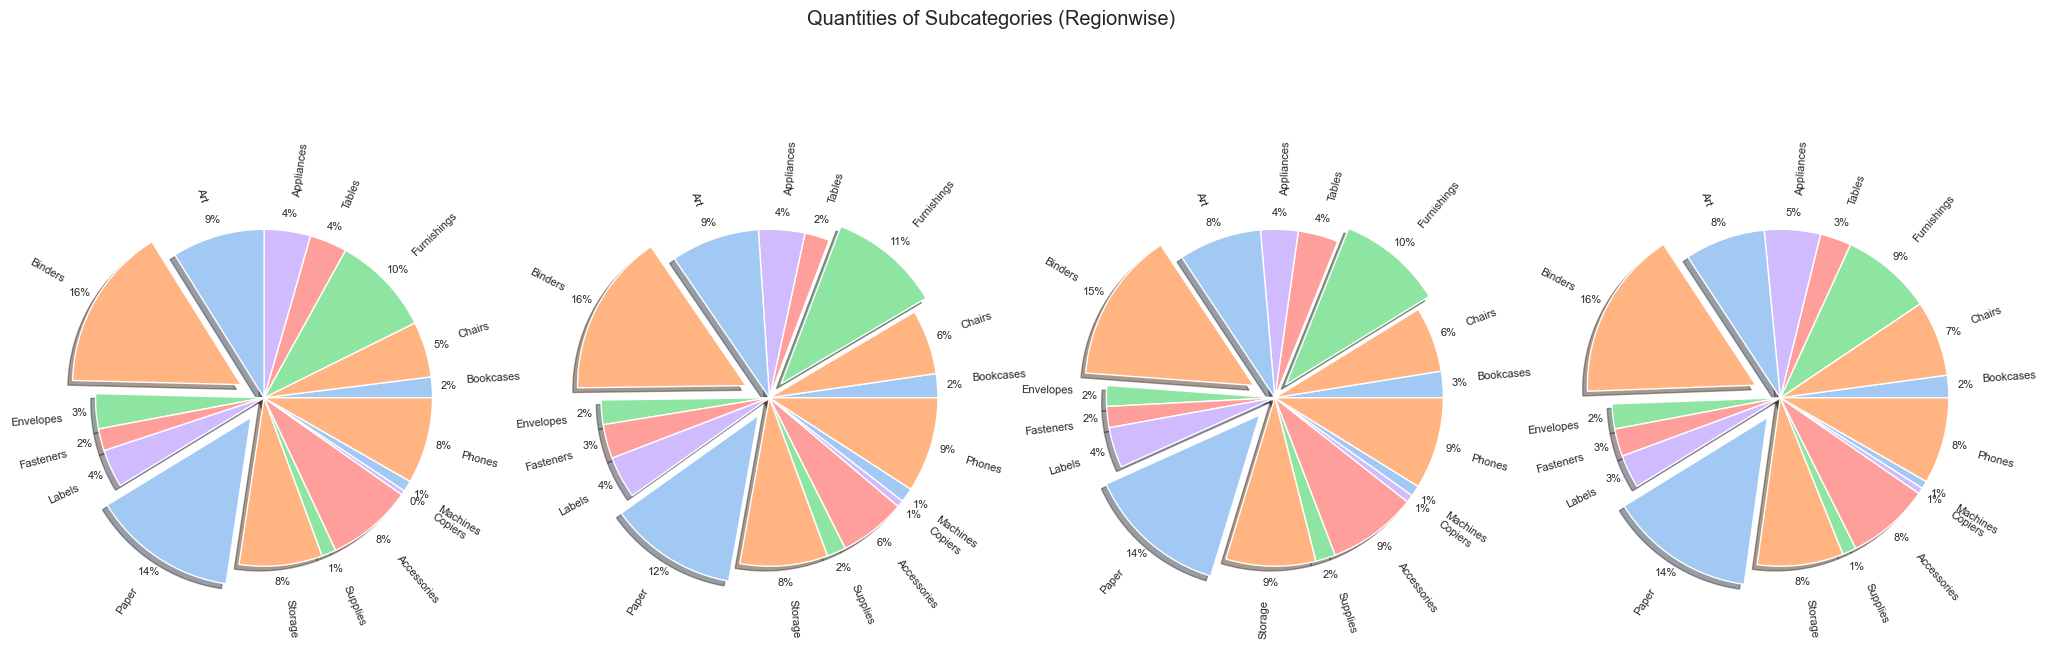

In [131]:
ea.create_pie_chart_from_multi_idx_df(
    multi_idx_df=data_temp,
    title="Quantities of Subcategories (Regionwise)",
    col_plotted="Quantity",
    ordering_sub_category=li_sub_category
    )

In [136]:
data_temp

Sales  Quantity      Profit  Profit Sign
Region  Sub-Category                                               
Central Accessories   32419.2340       677   7128.7216          1.0
        Appliances    23183.3950       455  -2558.3991         -1.0
        Art            5235.9780       654   1090.7058          1.0
        Binders       55473.3680      1383   3017.8171          1.0
        Bookcases     23663.7384       182  -1975.2899         -1.0
...                          ...       ...         ...          ...
West    Paper         22340.8060      1434  10115.1502          1.0
        Phones        85777.5880       931   8007.5539          1.0
        Storage       62544.8460       911   8069.7879          1.0
        Supplies      17122.3860       202    564.9391          1.0
        Tables        74442.2220       408   1300.2969          1.0

[68 rows x 4 columns]

# To adapt in module visualization

In [138]:
sns.barplot(data=data_temp.groupby(["Region","Sub-Category"],as_index=False)["Revenue"].sum(), x="Sub-Category", y="",hue="Region")

ValueError: Could not interpret input ''

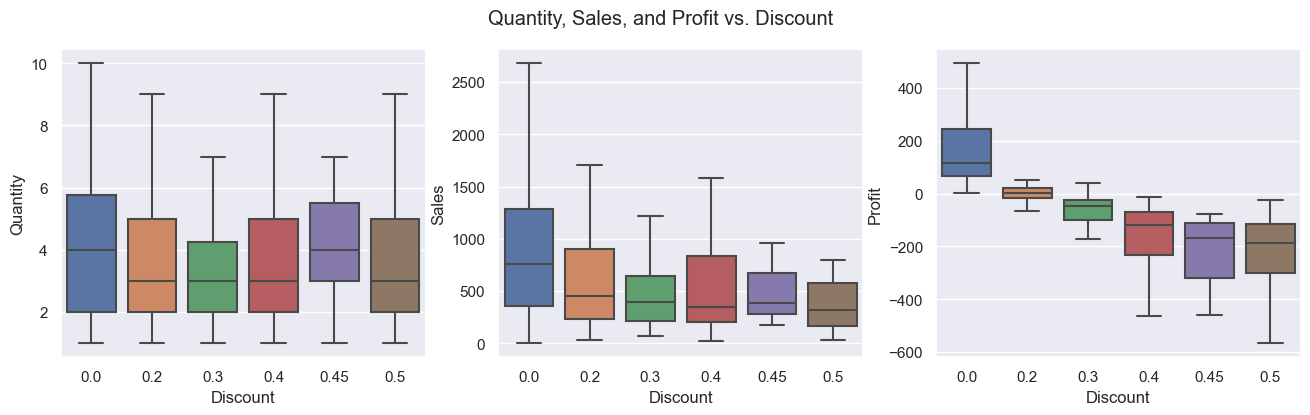

In [138]:
data=df_orders[df_orders["Sub-Category_Tables"]==1]
data=data[data["Returned"]=="No"]

li_y_features=["Quantity","Sales","Profit"]
x_feature="Discount"
title="Quantity, Sales, and Profit vs. Discount"
figsize=(16,4)
ea.plot_boxplots(data=data,li_y_features=li_y_features,x_feature=x_feature,title=title,figsize=figsize)

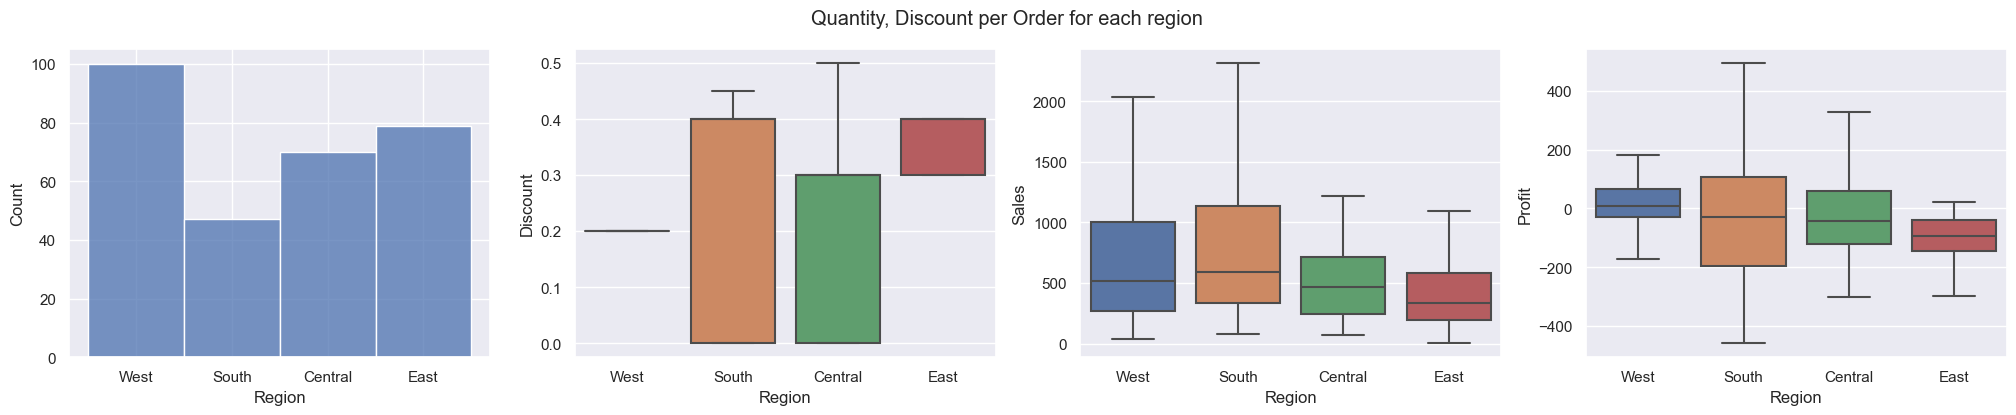

In [99]:
from matplotlib.pyplot import xlabel


fig, axes = plt.subplots(1, 4, figsize=(25,4))
fig.suptitle('Quantity, Discount per Order for each region')
sns.histplot(ax=axes[0],data=data, x="Region")
sns.boxplot(ax=axes[1],data=data,x="Region",y="Discount",showfliers=False);
sns.boxplot(ax=axes[2],data=data,x="Region",y="Sales",showfliers=False);
sns.boxplot(ax=axes[3],data=data,x="Region",y="Profit",showfliers=False);

Insights:
* In the west region, we have a high number of orders with discount at most 20%. Thus the combination yields tendencially profit
* In the central and east region we have relatively number of orders with tendencially higher discount. This yields loss tendencially.

In [100]:
data.groupby(["Region"],as_index=False)[["Sales","Profit","Quantity"]].sum()

,Region,Sales,Profit,Quantity
0,Central,38815.617,-3417.9520,253
1,East,36535.243,-10080.8520,253
2,South,41184.818,-4496.6166,213
3,West,74442.222,1300.2969,408


<AxesSubplot: xlabel='year', ylabel='Discount'>

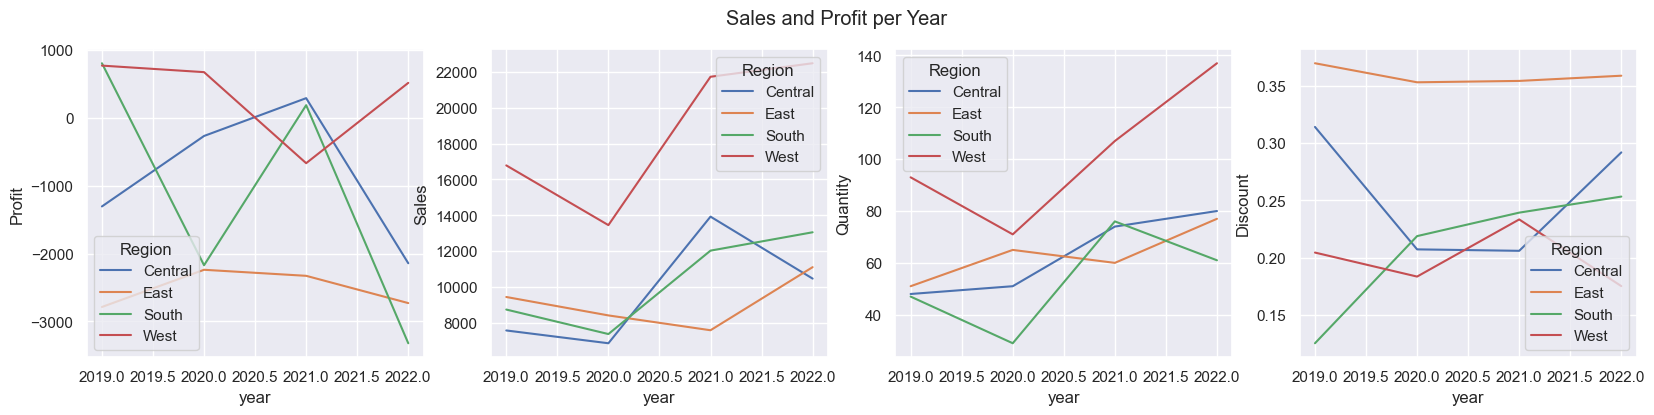

In [93]:
data_1=data.groupby(["Region","year"],as_index=False)[["Sales","Profit","Quantity"]].sum()
data_2=data.groupby(["Region","year"],as_index=False)[["Discount"]].mean()
year_region=data_1.join(data_2.set_index(["Region","year"]),on=["Region","year"])
fig, axes = plt.subplots(1, 4, figsize=(20,4))
fig.suptitle('Sales and Profit per Year')
sns.lineplot(ax=axes[0],data=year_region,x="year",y="Profit",hue="Region")
sns.lineplot(ax=axes[1],data=year_region,x="year",y="Sales",hue="Region")
sns.lineplot(ax=axes[2],data=year_region,x="year",y="Quantity",hue="Region")
sns.lineplot(ax=axes[3],data=year_region,x="year",y="Discount",hue="Region")

## Profit

### Profit and Segment

In [273]:
pd.DataFrame(df_orders["Profit"]).join(pd.get_dummies(df_orders["Segment"])).corr()

,Profit,Consumer,Corporate,Home Office
Profit,1.000000,0.000057,0.001125,-0.001469
Consumer,0.000057,1.000000,-0.702529,-0.473922
Corporate,0.001125,-0.702529,1.000000,-0.293716
Home Office,-0.001469,-0.473922,-0.293716,1.000000


Almost no correlation between profit and segment. We have only slight tendency of higher Profit in Consumer and Corporate segments, and of lower profit and higher loss in Home Office segment

# Profit and State/Province

In [282]:
corr_profit_state=pd.DataFrame(df_orders["Profit"]).join(pd.get_dummies(df_orders["State/Province"])).corr()["Profit"]
corr_profit_state[abs(corr_profit_state)>0.05]

Profit          1.000000
New York        0.070238
Ohio           -0.063626
Pennsylvania   -0.054326
Texas          -0.089032
Name: Profit, dtype: float64

There are also negligible correlation between Profit and States. We have slight tendency of positive profit in New York and negative profit in Ohio, Pennsylvania, and Texas.

# Profit, Category and Subcategory

In [284]:
pd.DataFrame(df_orders["Profit"]).join(pd.get_dummies(df_orders["Category"])).corr()["Profit"]

Profit             1.000000
Furniture         -0.035898
Office Supplies   -0.050263
Technology         0.101156
Name: Profit, dtype: float64

Slight positive correlation between ttechnology and profit

In [285]:
pd.DataFrame(df_orders["Profit"]).join(pd.get_dummies(df_orders["Sub-Category"])).corr()["Profit"]

Profit         1.000000
Accessories    0.026788
Appliances     0.019098
Art           -0.024767
Binders       -0.033628
Bookcases     -0.025986
Chairs         0.022593
Copiers        0.292124
Envelopes     -0.000795
Fasteners     -0.012778
Furnishings   -0.017748
Labels        -0.009311
Machines       0.004815
Paper         -0.006561
Phones         0.026765
Storage       -0.005020
Supplies      -0.018785
Tables        -0.063798
Name: Profit, dtype: float64

Copiers almost non-negigible correlation

## Days until shipping and Churn

In [291]:
pd.DataFrame(df_orders["Days Until Shipping"]).join(pd.get_dummies(df_orders["Returned"])).corr()

,Days Until Shipping,No,Yes
Days Until Shipping,1.000000,0.051606,-0.051606
No,0.051606,1.000000,-1.000000
Yes,-0.051606,-1.000000,1.000000


## Profit and Region

<AxesSubplot: xlabel='year', ylabel='Discount'>

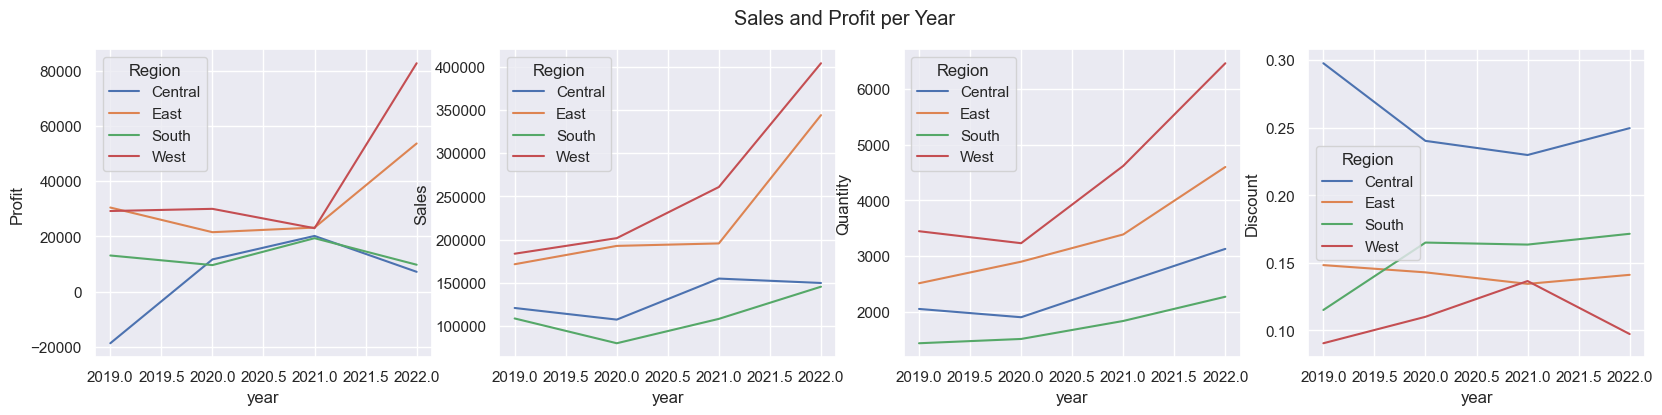

In [380]:
data_1=df_orders.groupby(["Region","year"],as_index=False)[["Sales","Profit","Quantity"]].sum()
data_2=df_orders.groupby(["Region","year"],as_index=False)[["Discount"]].mean()
year_region=data_1.join(data_2.set_index(["Region","year"]),on=["Region","year"])
fig, axes = plt.subplots(1, 4, figsize=(20,4))
fig.suptitle('Sales and Profit per Year')
sns.lineplot(ax=axes[0],data=year_region,x="year",y="Profit",hue="Region")
sns.lineplot(ax=axes[1],data=year_region,x="year",y="Sales",hue="Region")
sns.lineplot(ax=axes[2],data=year_region,x="year",y="Quantity",hue="Region")
sns.lineplot(ax=axes[3],data=year_region,x="year",y="Discount",hue="Region")

In [384]:
df_orders[df_orders["Region"]=="Central"].groupby(["Product Name","Order Date"]).sum()

/var/folders/6y/6950x6wj5s11qnv2r99pvgt80000gn/T/ipykernel_40107/1835203197.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_orders[df_orders["Region"]=="Central"].groupby(["Product Name","Order Date"]).sum()


Row ID  \
Product Name                                       Order Date           
"While you Were Out" Message Book, One Form per... 2022-09-03    8532   
#10 Gummed Flap White Envelopes, 100/Box           2020-11-03    3558   
                                                   2022-10-31    9251   
#10 White Business Envelopes,4 1/8 x 9 1/2         2019-11-16    1594   
#10- 4 1/8" x 9 1/2" Recycled Envelopes            2019-06-06     588   
...                                                               ...   
Zipper Ring Binder Pockets                         2022-11-06    9349   
iKross Bluetooth Portable Keyboard + Cell Phone... 2020-06-01    2637   
                                                   2021-10-20    5999   
invisibleSHIELD by ZAGG Smudge-Free Screen Prot... 2021-11-19    6315   
netTALK DUO VoIP Telephone Service                 2022-07-03    8050   

                                                                 Sales  \
Product Name                                       Order Date            
"While you Were Out" Message Book, One Form per... 2022-09-03    8.904   
#10 Gummed Flap White Envelopes, 100/Box           2020-11-03    6.608   
                                                   2022-10-31    9.912   
#10 White Business Envelopes,4 1/8 x 9 1/2         2019-11-16   78.350   
#10- 4 1/8" x 9 1/2" Recycled Envelopes            2019-06-06   13.984   
...                                                                ...   
Zipper Ring Binder Pockets                         2022-11-06    1.248   
iKross Bluetooth Portable Keyboard + Cell Phone... 2020-06-01   41.900   
                                                   2021-10-20  125.700   
invisibleSHIELD by ZAGG Smudge-Free Screen Prot... 2021-11-19   71.960   
netTALK DUO VoIP Telephone Service                 2022-07-03  167.968   

                                                               Quantity  \
Product Name                                       Order Date             
"While you Were Out" Message Book, One Form per... 2022-09-03         3   
#10 Gummed Flap White Envelopes, 100/Box           2020-11-03         2   
                                                   2022-10-31         3   
#10 White Business Envelopes,4 1/8 x 9 1/2         2019-11-16         5   
#10- 4 1/8" x 9 1/2" Recycled Envelopes            2019-06-06         2   
...                                                                 ...   
Zipper Ring Binder Pockets                         2022-11-06         2   
iKross Bluetooth Portable Keyboard + Cell Phone... 2020-06-01         2   
                                                   2021-10-20         6   
invisibleSHIELD by ZAGG Smudge-Free Screen Prot... 2021-11-19         5   
netTALK DUO VoIP Telephone Service                 2022-07-03         4   

                                                               Discount  \
Product Name                                       Order Date             
"While you Were Out" Message Book, One Form per... 2022-09-03       0.2   
#10 Gummed Flap White Envelopes, 100/Box           2020-11-03       0.2   
                                                   2022-10-31       0.2   
#10 White Business Envelopes,4 1/8 x 9 1/2         2019-11-16       0.0   
#10- 4 1/8" x 9 1/2" Recycled Envelopes            2019-06-06       0.2   
...                                                                 ...   
Zipper Ring Binder Pockets                         2022-11-06       0.8   
iKross Bluetooth Portable Keyboard + Cell Phone... 2020-06-01       0.0   
                                                   2021-10-20       0.0   
invisibleSHIELD by ZAGG Smudge-Free Screen Prot... 2021-11-19       0.2   
netTALK DUO VoIP Telephone Service                 2022-07-03       0.2   

                                                                Profit  year  \
Product Name                                       Order Date                  
"While you Were Out" Message Book, One

In [364]:
data_1

,Region,year,Sales,Profit,Quantity
0,Central,2019,121004.4846,-18655.6805,2050
1,Central,2020,107564.6920,11686.9034,1901
2,Central,2021,154998.2870,20186.0489,2518
3,Central,2022,149915.6586,7200.2569,3128
4,East,2019,171596.4290,30467.9351,2511
5,East,2020,192786.9670,21541.1412,2898
6,East,2021,195647.5250,23209.5528,3387
7,East,2022,343972.8240,53648.8908,4598
8,South,2019,108898.5095,13105.9214,1434
9,South,2020,80228.1905,9630.0009,1511


In [365]:
data_1=df_orders.groupby(["Region","year"],as_index=False)[["Sales","Profit","Quantity"]].sum()
data_2=df_orders.groupby(["Region","year"],as_index=False)[["Discount"]].median()
year_region=data_1.join(data_2.set_index(["Region","year"]),on=["Region","year"])

,Region,year,Sales,Profit,Quantity,Discount
0,Central,2019,121004.4846,-18655.6805,2050,0.2
1,Central,2020,107564.6920,11686.9034,1901,0.2
2,Central,2021,154998.2870,20186.0489,2518,0.2
3,Central,2022,149915.6586,7200.2569,3128,0.2
4,East,2019,171596.4290,30467.9351,2511,0.0
5,East,2020,192786.9670,21541.1412,2898,0.0
6,East,2021,195647.5250,23209.5528,3387,0.0
7,East,2022,343972.8240,53648.8908,4598,0.0
8,South,2019,108898.5095,13105.9214,1434,0.0
9,South,2020,80228.1905,9630.0009,1511,0.2


# Churn Analysis

To analyze the impact of churns to the company's profitability. We first need to input the churn information into the order dataframe:

In [156]:
df_orders=df_orders.merge(df_returns, on=['Order ID'], how='left')
df_orders["Returned"]=df_orders["Returned"].fillna("No")

In [157]:
df_orders_churn_del=df_orders[df_orders["Returned"]=="No"].copy()
churned_orders=df_orders[df_orders["Returned"]=="Yes"].copy()

In [48]:
print(f"Order churn rate: {round(round(churned_orders['Order ID'].nunique()/df_orders['Order ID'].nunique(),3)*100,2)}%")

Order churn rate: 5.8%


In [49]:
print(f"Percentage consumer having at least one returned order: {round((churned_orders['Customer Name'].nunique()/df_orders['Customer Name'].nunique())*100,2)}%")

Percentage consumer having at least one returned order: 30.88%


## Missing profit by churn

In [50]:
profit=df_orders["Profit"].sum()
profit_churn_deleted=df_orders_churn_del["Profit"].sum()
print(f"With no churn, the total profit should increases about: {round(((profit-profit_churn_deleted)/profit_churn_deleted)*100,2)}% ")

With no churn, the total profit should increases about: 36.04% 


In [61]:
yearly_profit=pd.DataFrame(df_orders.groupby("year")["Profit"].sum().reset_index())
yearly_profit_churn_deleted=pd.DataFrame(df_orders_churn_del.groupby("year")["Profit"].sum().reset_index()).rename(columns={"Profit":"Profit churn deleted"})
profit_comp_churn=ba.merge_columns([yearly_profit,yearly_profit_churn_deleted],"year")
profit_comp_churn["Increase Should in perc"]=(((profit_comp_churn["Profit"]-profit_comp_churn["Profit churn deleted"])/profit_comp_churn["Profit churn deleted"])*100).round(2)
profit_comp_churn


,year,Profit,Profit churn deleted,Increase Should in perc
0,2019,54124.1695,51213.6186,5.68
1,2020,72849.9431,57598.9395,26.48
2,2021,85752.2320,80052.8161,7.12
3,2022,153302.9578,80199.0789,91.15


## Churn by Category

In [69]:
churned_orders.groupby(["Category"])["Category"].count()

Category
Furniture           671
Office Supplies    1919
Technology          636
Name: Category, dtype: int64

In [68]:
churned_orders.groupby(["Category","year"])["Category"].count()

Category         year
Furniture        2019    109
                 2020    114
                 2021    142
                 2022    306
Office Supplies  2019    364
                 2020    336
                 2021    527
                 2022    692
Technology       2019    126
                 2020    133
                 2021    120
                 2022    257
Name: Category, dtype: int64

In [74]:
churned_orders.groupby(["State/Province","year"])["Order ID"].nunique()

State/Province  year
Alabama         2019     1
Arizona         2020     3
                2021     3
                2022     3
California      2019    17
                        ..
Washington      2019     8
                2020     3
                2021     7
                2022    11
Wisconsin       2022     2
Name: Order ID, Length: 81, dtype: int64

# Discount Analysis

In [174]:
df_disc_prof=df_orders[["Discount","Profit","year","Quantity","Category","Sales"]].copy()
df_disc_prof["Average Profit per Quantity"]=df_disc_prof["Profit"]/df_disc_prof["Quantity"]
df_disc_prof["Average Sales per Quantity"]=df_disc_prof["Sales"]/df_disc_prof["Quantity"]
df_disc_prof

,Discount,Profit,year,Quantity,Category,Sales,Average Profit per Quantity,Average Sales per Quantity
0,0.2,5.5512,2019,2,Office Supplies,16.448,2.7756,8.224
1,0.8,-5.4870,2019,2,Office Supplies,3.540,-2.7435,1.770
2,0.2,4.2717,2019,3,Office Supplies,11.784,1.4239,3.928
3,0.2,-64.7748,2019,3,Office Supplies,272.736,-21.5916,90.912
4,0.2,4.8840,2019,3,Office Supplies,19.536,1.6280,6.512
...,...,...,...,...,...,...,...,...
12615,0.2,6.4750,2022,2,Office Supplies,20.720,3.2375,10.360
12616,0.2,6.4750,2022,2,Office Supplies,20.720,3.2375,10.360
12617,0.2,-0.6048,2022,3,Office Supplies,3.024,-0.2016,1.008
12618,0.0,2.7279,2022,7,Technology,90.930,0.3897,12.990


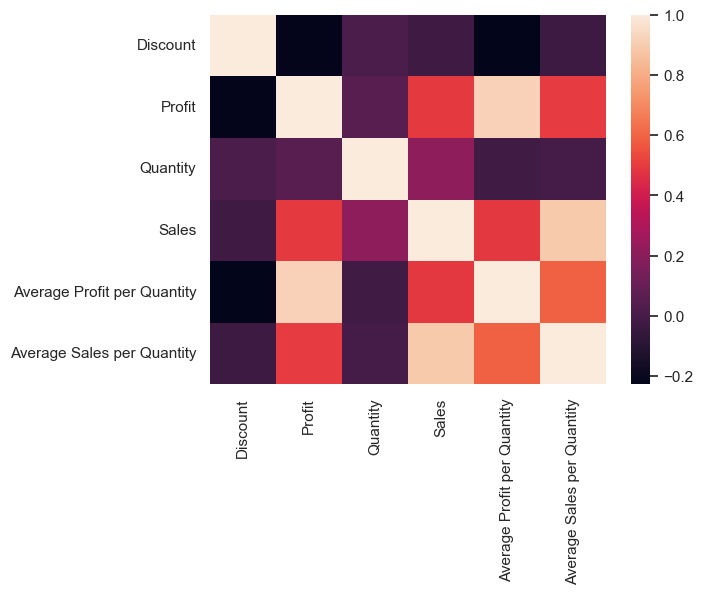

In [230]:
sns.heatmap(df_disc_prof.drop(columns=["Category","year"]).corr());

## Do higher discount boost the sales?

### Analysis per Order

In [189]:
#sns.jointplot(data=df_disc_prof,x="Discount",y="Sales",kind="reg");

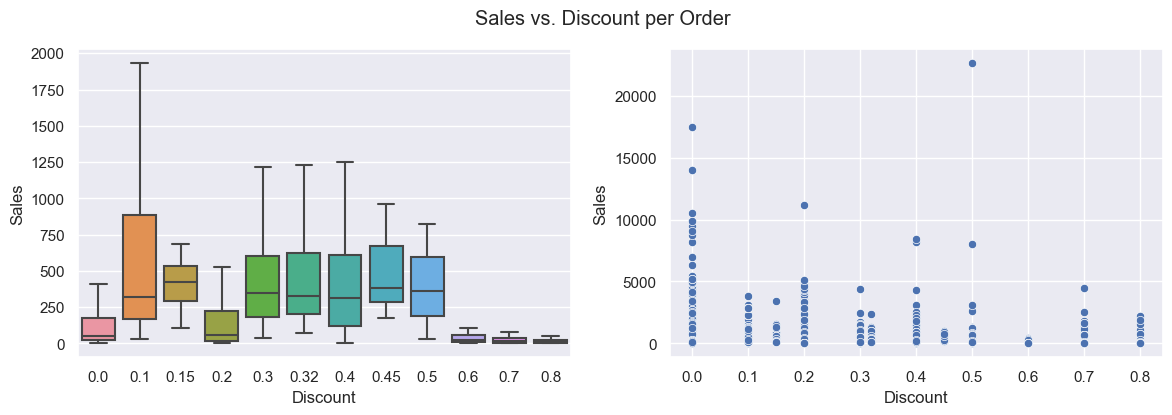

In [205]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))
fig.suptitle('Sales vs. Discount per Order')
sns.boxplot(ax=axes[0],data=df_disc_prof,x="Discount",y="Sales",showfliers=False);
sns.scatterplot(ax=axes[1],data=df_disc_prof,x="Discount",y="Sales");

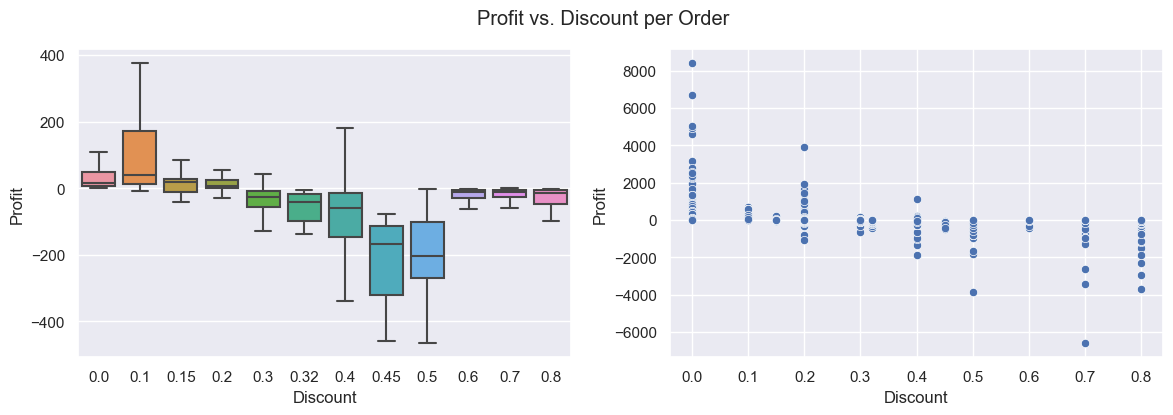

In [221]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))
fig.suptitle('Profit vs. Discount per Order')
sns.boxplot(ax=axes[0],data=df_disc_prof,x="Discount",y="Profit",showfliers=False);
sns.scatterplot(ax=axes[1],data=df_disc_prof,x="Discount",y="Profit");

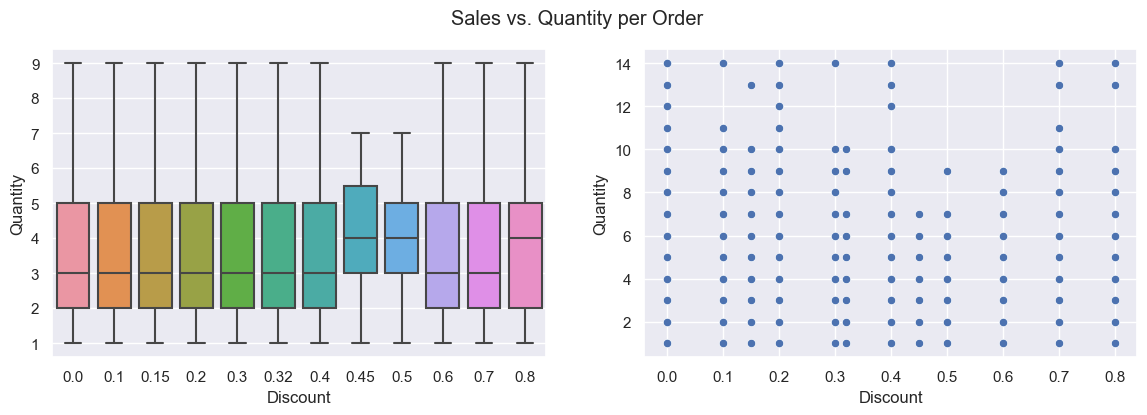

In [211]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))
fig.suptitle('Sales vs. Quantity per Order')
sns.boxplot(ax=axes[0],data=df_disc_prof,x="Discount",y="Quantity",showfliers=False);
sns.scatterplot(ax=axes[1],data=df_disc_prof,x="Discount",y="Quantity");

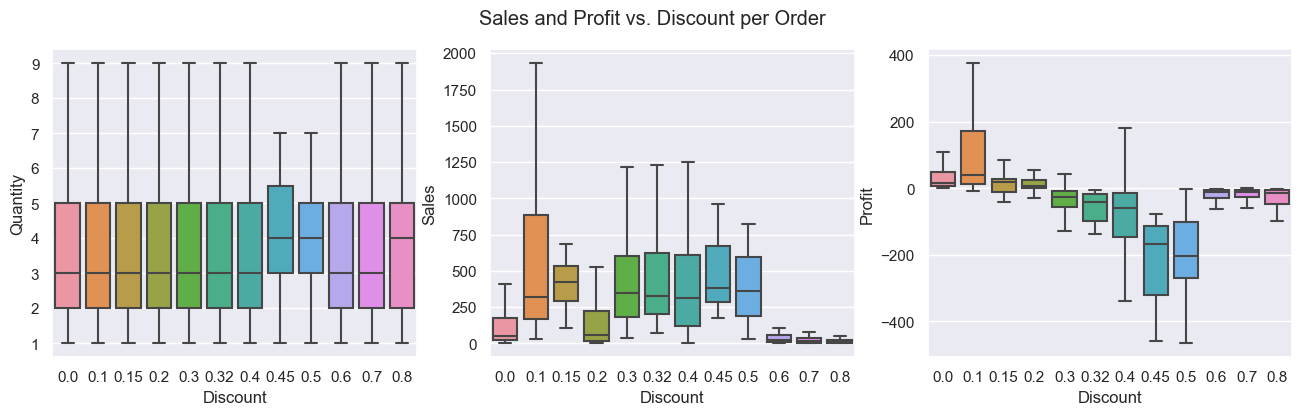

In [214]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
fig.suptitle('Quantity, Sales, and Profit vs. Discount per Order')
sns.boxplot(ax=axes[0],data=df_disc_prof,x="Discount",y="Quantity",showfliers=False);
sns.boxplot(ax=axes[1],data=df_disc_prof,x="Discount",y="Sales",showfliers=False);
sns.boxplot(ax=axes[2],data=df_disc_prof,x="Discount",y="Profit",showfliers=False);

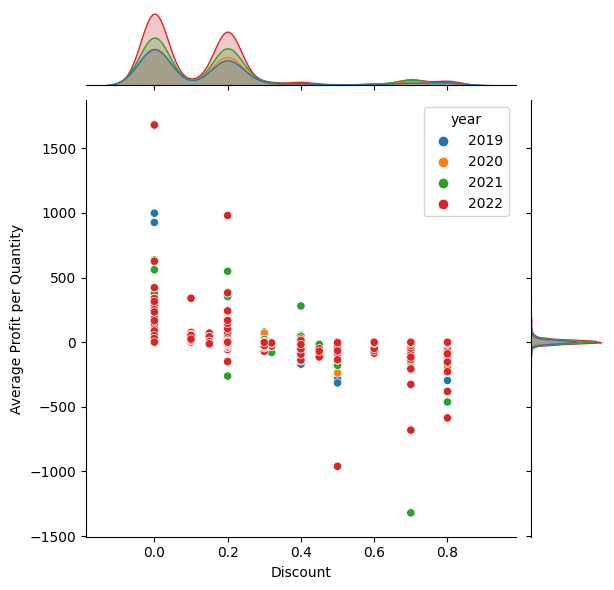

In [165]:
sns.jointplot(data=df_disc_prof, x="Discount", y="Average Profit per Quantity",hue="year")

### Analysis per product

In [219]:
data=df_orders.groupby(["Product Name","Discount"],as_index=False)[["Quantity","Sales","Profit"]].sum()
data=data[["Quantity","Sales","Profit","Discount"]]
data

,Quantity,Sales,Profit,Discount
0,12,44.520,22.2600,0.0
1,6,17.808,6.6780,0.2
2,6,24.780,11.3988,0.0
3,5,16.520,5.3690,0.2
4,9,99.810,48.9069,0.0
...,...,...,...,...
4107,10,179.900,86.3520,0.0
4108,16,230.272,80.5952,0.2
4109,3,32.382,4.3176,0.4
4110,2,104.980,52.4900,0.0


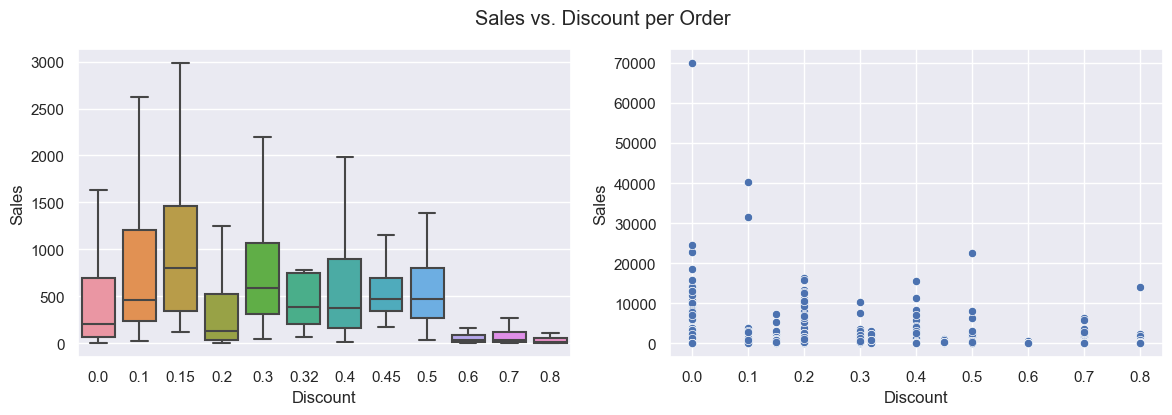

In [220]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))
fig.suptitle('Sales vs. Discount per Order')
sns.boxplot(ax=axes[0],data=data,x="Discount",y="Sales",showfliers=False);
sns.scatterplot(ax=axes[1],data=data,x="Discount",y="Sales");

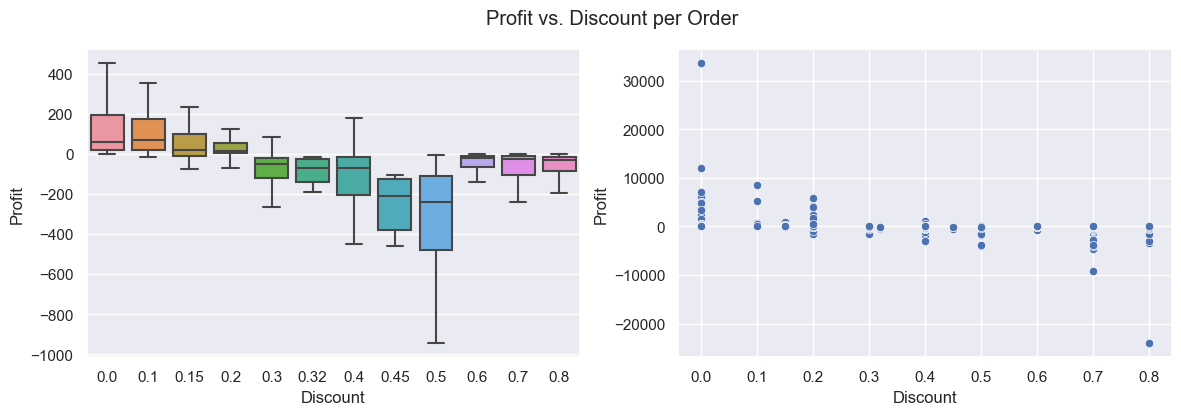

In [222]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))
fig.suptitle('Profit vs. Discount per Order')
sns.boxplot(ax=axes[0],data=data,x="Discount",y="Profit",showfliers=False);
sns.scatterplot(ax=axes[1],data=data,x="Discount",y="Profit");

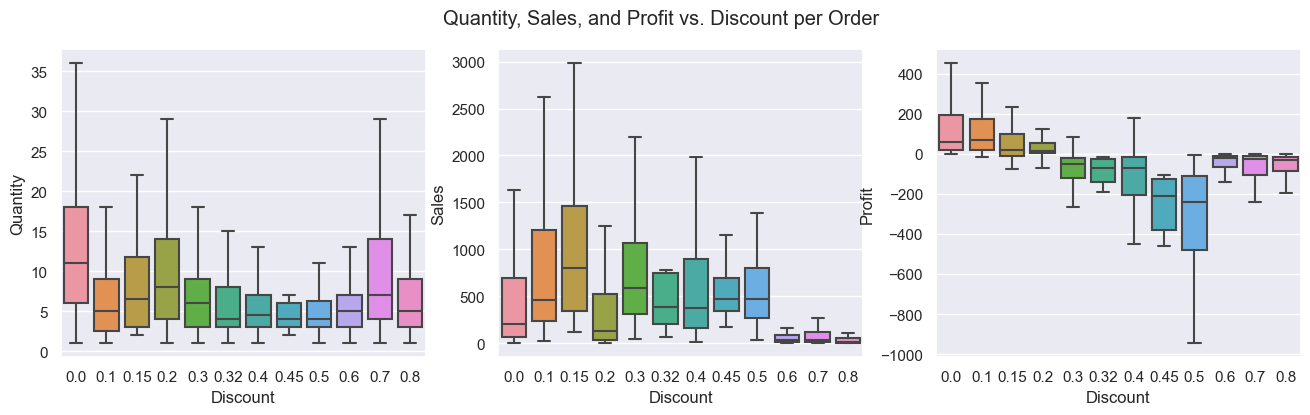

In [223]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
fig.suptitle('Quantity, Sales, and Profit vs. Discount per Order')
sns.boxplot(ax=axes[0],data=data,x="Discount",y="Quantity",showfliers=False);
sns.boxplot(ax=axes[1],data=data,x="Discount",y="Sales",showfliers=False);
sns.boxplot(ax=axes[2],data=data,x="Discount",y="Profit",showfliers=False);

In [123]:
data=df_orders.groupby(["Product Name","Discount"],as_index=False)["Quantity"].sum()[["Discount","Quantity"]]

In [135]:
data=df_orders.groupby(["Product Name","Discount","State/Province"],as_index=False)["Quantity"].sum()[["Discount","Quantity"]]

In [142]:
df_orders.groupby(["Product Name","Discount","State/Province"],as_index=False)["Quantity"].sum()

,Product Name,Discount,State/Province,Quantity
0,"""While you Were Out"" Message Book, One Form pe...",0.0,California,12
1,"""While you Were Out"" Message Book, One Form pe...",0.2,Illinois,3
2,"""While you Were Out"" Message Book, One Form pe...",0.2,Tennessee,3
3,"#10 Gummed Flap White Envelopes, 100/Box",0.0,New York,6
4,"#10 Gummed Flap White Envelopes, 100/Box",0.2,Illinois,3
...,...,...,...,...
8284,invisibleSHIELD by ZAGG Smudge-Free Screen Pro...,0.4,Pennsylvania,3
8285,netTALK DUO VoIP Telephone Service,0.0,New Jersey,2
8286,netTALK DUO VoIP Telephone Service,0.2,Arizona,4
8287,netTALK DUO VoIP Telephone Service,0.2,California,20


In [145]:
df_orders.groupby(["Product Name","Discount","State/Province"],as_index=False)["Quantity"].sum().groupby(["Discount"]).median()

/var/folders/6y/6950x6wj5s11qnv2r99pvgt80000gn/T/ipykernel_40107/1507949379.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_orders.groupby(["Product Name","Discount","State/Province"],as_index=False)["Quantity"].sum().groupby(["Discount"]).median()


,Quantity
Discount,
0.00,4.0
0.10,5.0
0.15,6.5
0.20,4.0
0.30,4.0
0.32,4.0
0.40,4.0
0.45,4.0
0.50,4.0


In [127]:
data

,Discount,Quantity
0,0.0,12
1,0.2,6
2,0.0,6
3,0.2,5
4,0.0,9
...,...,...
4107,0.0,10
4108,0.2,16
4109,0.4,3
4110,0.0,2


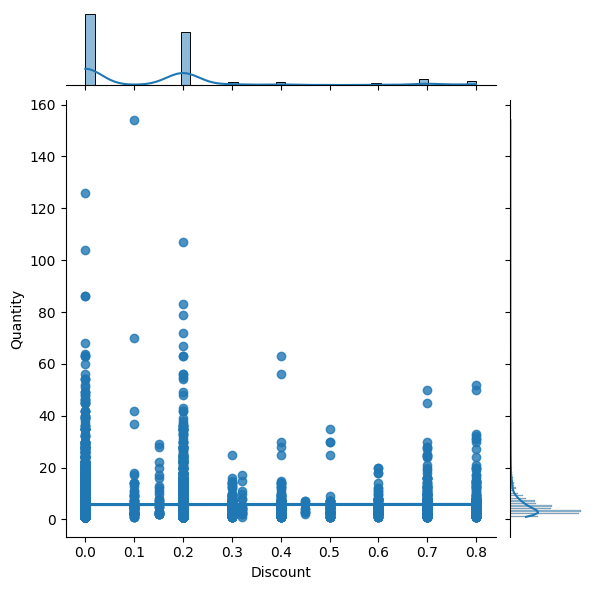

In [150]:
sns.jointplot(data=data,x="Discount",y="Quantity",kind="reg")

<AxesSubplot: xlabel='Discount', ylabel='Quantity'>

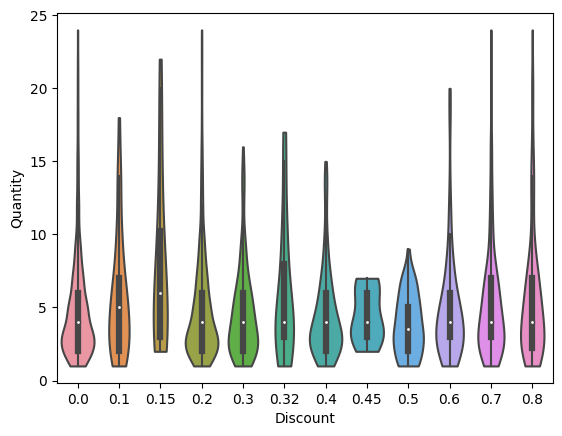

In [151]:
sns.violinplot(data=data[data["Quantity"]<25],x="Discount",y="Quantity",showfliers=False,cut=0)

<AxesSubplot: xlabel='Discount', ylabel='Quantity'>

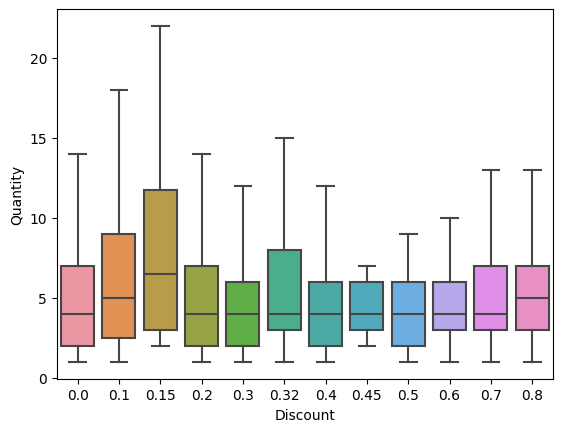

In [153]:
sns.boxplot(data=data,x="Discount",y="Quantity",showfliers=False)